# Correlated Truncation Errors in for Realistic NN Interactions in Chiral Effective Field Theory

This notebook provides the code to reproduce all of the plots from Melendez et al. (2019).
Notebook written by Jordan Melendez.
Commentary by Daniel Phillips and Dick Furnstahl, June 2019.


*Note*: Since publication we have switched the `pivoted_cholesky` function from an underlying GSL to a LAPACK routine.
Their output is generally identical but the exact results can differ very slightly depending on fine details of the input matrix.
Thus some of the PC plots may not be identical to their published versions, but the overall conclusions remain unchanged. (Currently only Fig. 7(c) has changed.)

In [1]:
import gsum as gm
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import interp1d
import os
import h5py
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
import math
import re
from ChEFT_GP_imports import joint_plot, offset_xlabel, m_p, m_n, hbarc, E_to_p, Q_approx, \
deg_to_qcm, deg_to_qcm2, softmax_mom, GPHyperparameters, FileNaming, PosteriorBounds, \
OrderInfo, versatile_train_test_split, VsAngleObj, VsEnergyObj, InputSpaceBunch, \
ObservableBunch, Interpolation, TrainTestSplit, ScaleSchemeBunch

import urllib
import tables

%matplotlib inline
%load_ext autoreload
%autoreload 2

In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\pjmil\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

In [2]:
# See: https://ianstormtaylor.com/design-tip-never-use-black/
# softblack = '#262626'
softblack = 'k'  # Looks better when printed on tex file
gray = '0.7'

mpl.rcParams['figure.dpi'] = 180
mpl.rcParams['font.size'] = 9
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'

mpl.rcParams['axes.labelsize'] = 9
mpl.rcParams['axes.edgecolor'] = softblack
mpl.rcParams['axes.xmargin'] = 0
mpl.rcParams['axes.labelcolor'] = softblack
mpl.rcParams['axes.linewidth']

mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['xtick.labelsize'] = 9
mpl.rcParams['ytick.labelsize'] = 9
mpl.rcParams['xtick.color'] = softblack
mpl.rcParams['ytick.color'] = softblack
mpl.rcParams['xtick.minor.size'] = 2.4
mpl.rcParams['ytick.minor.size'] = 2.4

mpl.rcParams['legend.title_fontsize'] = 9
mpl.rcParams['legend.fontsize'] = 9
mpl.rcParams['legend.edgecolor'] = 'inherit'  # inherits from axes.edgecolor, to match
mpl.rcParams['legend.facecolor'] = (1, 1, 1, 0.6)  # Set facecolor with its own alpha, so edgecolor is unaffected
mpl.rcParams['legend.fancybox'] = True
mpl.rcParams['legend.borderaxespad'] = 0.8
mpl.rcParams['legend.framealpha'] = None  # Do not set overall alpha (affects edgecolor). Handled by facecolor above
mpl.rcParams['patch.linewidth'] = 0.8  # This is for legend edgewidth, since it does not have its own option

text_bbox = dict(boxstyle='round', fc=(1, 1, 1, 0.6), ec=softblack, lw=0.8)
mpl.rc('savefig', transparent=False, bbox='tight', pad_inches=0.05, dpi=300, format='pdf')

edgewidth = 0.6

## NN Scattering in Chiral EFT

In the last section of the paper we turn our attention to NN scattering in Chiral EFT. We apply the above ideas to the differential cross section vs angle at $E_{\rm lab}=150$ MeV, to the total cross section vs energy, and to the spin observable $A$ at 96 MeV.

In [3]:
# # We get the NN data from a separate place in our github respository.
# nn_online_pot = 'pwa93'
# nn_online_url = 'https://github.com/buqeye/buqeyebox/blob/master/nn_scattering/NN-online-Observables.h5?raw=true'
# nno_response = urllib.request.urlopen(nn_online_url) 
# nn_online_file = tables.open_file("nn_online_example.h5", driver="H5FD_CORE",
#                           driver_core_image=nno_response.read(),
#                           driver_core_backing_store=0)
# SGT_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/SGT').read()
# DSG_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/DSG').read()[:, :-1]
# AY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/PB').read()[:, :-1]
# A_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/A').read()[:, :-1]
# D_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/D').read()[:, :-1]
# AXX_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AXX').read()[:, :-1]
# AYY_nn_online = nn_online_file.get_node('/' + nn_online_pot + '/AYY').read()[:, :-1]

In [4]:
# for each choice of scale and scheme, sets the total orders and nomenclature
EKM0p8fm = ScaleSchemeBunch('scattering_observables_EKM_R-0p8fm.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EKM", "0p8fm")
EKM0p9fm = ScaleSchemeBunch('scattering_observables_EKM_R-0p9fm.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EKM", "0p9fm")
EKM1p0fm = ScaleSchemeBunch('scattering_observables_EKM_R-1p0fm.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EKM", "1p0fm")
EKM1p1fm = ScaleSchemeBunch('scattering_observables_EKM_R-1p1fm.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EKM", "1p1fm")
EKM1p2fm = ScaleSchemeBunch('scattering_observables_EKM_R-1p2fm.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EKM", "1p2fm")

RKE400MeV = ScaleSchemeBunch('scattering_observables_RKE_L-400MeV.h5', \
            np.array([0, 2, 3, 4, 5, 6]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']], \
            "RKE", "400MeV")
RKE450MeV = ScaleSchemeBunch('scattering_observables_RKE_L-450MeV.h5', \
            np.array([0, 2, 3, 4, 5, 6]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']], \
            "RKE", "450MeV")
RKE500MeV = ScaleSchemeBunch('scattering_observables_RKE_L-500MeV.h5', \
            np.array([0, 2, 3, 4, 5, 6]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']], \
            "RKE", "500MeV")
RKE550MeV = ScaleSchemeBunch('scattering_observables_RKE_L-550MeV.h5', \
            np.array([0, 2, 3, 4, 5, 6]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds', 'Purples']], \
            "RKE", "550MeV")

EMN450MeV = ScaleSchemeBunch('scattering_observables_EM-450MeV.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EMN", "450MeV")
EMN500MeV = ScaleSchemeBunch('scattering_observables_EM-500MeV.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EMN", "500MeV")
EMN550MeV = ScaleSchemeBunch('scattering_observables_EM-550MeV.h5', \
            np.array([0, 2, 3, 4, 5]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens', 'Blues', 'Reds']], \
            "EMN", "550MeV")

GT0p9fm = ScaleSchemeBunch('scattering_observables_Gezerlis-0p9fm.h5', \
            np.array([0, 2, 3]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens']], \
            "GT", "0p9fm")
GT1p0fm = ScaleSchemeBunch('scattering_observables_Gezerlis-1p0fm.h5', \
            np.array([0, 2, 3]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens']], \
            "GT", "1p0fm")
GT1p1fm = ScaleSchemeBunch('scattering_observables_Gezerlis-1p1fm.h5', \
            np.array([0, 2, 3]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens']], \
            "GT", "1p1fm")
GT1p2fm = ScaleSchemeBunch('scattering_observables_Gezerlis-1p2fm.h5', \
            np.array([0, 2, 3]), \
            [plt.get_cmap(name) for name in ['Oranges', 'Greens']], \
            "GT", "1p2fm")

In [5]:
MyScaleScheme = EMN550MeV

SGT = MyScaleScheme.get_data('SGT')
DSG = MyScaleScheme.get_data('DSG')
print("DSG = " + str(DSG))
AY = MyScaleScheme.get_data('PB')
A = MyScaleScheme.get_data('A')
print("A = " + str(A))
D = MyScaleScheme.get_data('D')
AXX = MyScaleScheme.get_data('AXX')
AYY = MyScaleScheme.get_data('AYY')
q_cm = MyScaleScheme.get_data('q_cm') * hbarc
t_lab = MyScaleScheme.get_data('t_lab')
degrees = MyScaleScheme.get_data('degrees')

DSG = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.99370492]
  [  4.76482432   4.75475582   4.73829797 ...   2.95872648   2.97799605
     2.99009312]
 

In [6]:
# This ensures we only analyze the non-trivial information at
# O(Q^2), O(Q^3), O(Q^4), and O(Q^5)
excluded = [0]
nn_orders_mask = ~ np.isin(MyScaleScheme.nn_orders, excluded)
Lambdab = 600

In [7]:
# sets the method for parametrizing the dimensionless parameter Q
# Q_param_method_array = ["poly", "max", "sum"]
Q_param_method_array = ["sum"]

### Angle-dependent observables

In [8]:
# creates the training and testing masks for the total cross section
Fullspaceanglessplit = TrainTestSplit("allangles", 6, 3, \
                                    xmin_train_factor = 0, xmax_train_factor = 1)
Forwardanglessplit = TrainTestSplit("forward", 6, 3, \
                                    xmin_train_factor = 0, xmax_train_factor = 5/6)
Backwardanglessplit = TrainTestSplit("backward", 6, 3, \
                                    xmin_train_factor = 1/6, xmax_train_factor = 1)
traintestsplit_vsangle_array = [Fullspaceanglessplit, Forwardanglessplit, Backwardanglessplit]

In [9]:
# # arrays for starting guesses for GP length scale
# E_dsg_array = [50, 100, 150, 200, 250, 300]
# length_scale_dsg_array = np.array([[40, 40, 40, 40, 40, 40], \
#                      [0.4, 0.4, 0.4, 0.4, 0.4, 0.4], \
#                      [40, 45, 50, 55, 60, 65], \
#                      [12000, 23000, 33000, 50000, 90000, 120000]])
E_dsg_array = [150]
length_scale_dsg_array = np.array([[40], \
                     [0.4], \
                     [50], \
                     [33000]])

E_a_array = [96, 192, 288]
length_scale_a_array = np.array([[30, 30, 30], \
                     [0.35, 0.35, 0.35], \
                     [35, 50, 65], \
                     [23000, 50000, 120000]])

In [10]:
# bounds for 2D posterior PDF figures
PosteriorBounds_deg = PosteriorBounds(1e-6, 100, 100, 300, 900, 300)
PosteriorBounds_cos = PosteriorBounds(1e-6, 2, 100, 300, 900, 300)

In [11]:
# creates the bunch for each observable to be plotted against angle
DSGBunch = ObservableBunch("DSG", DSG, E_dsg_array, length_scale_dsg_array, '\sigma', \
                           "dimensionful")
ABunch = ObservableBunch("A", A, E_a_array, length_scale_a_array, 'A', \
                           "dimensionless")

vsangle_observable_array = [DSGBunch, ABunch]

test first: 1 10.88888888888889
test last: 179 169.11111111111111
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.99370492]
  [  4.76482432   4.754

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


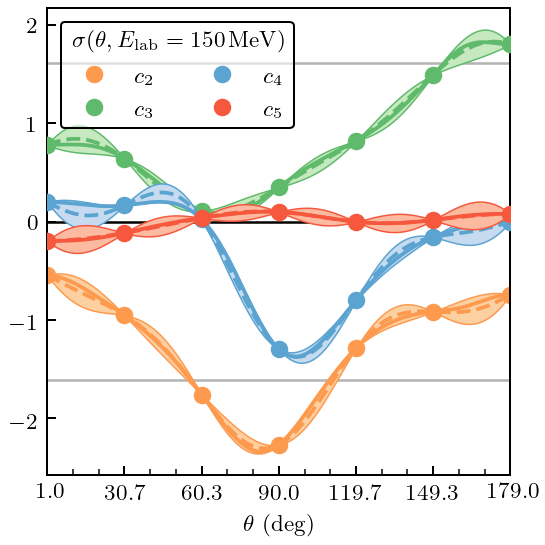

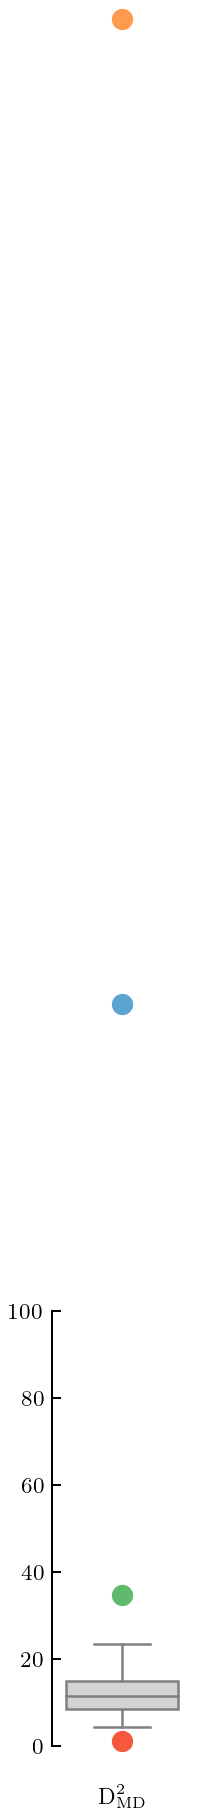

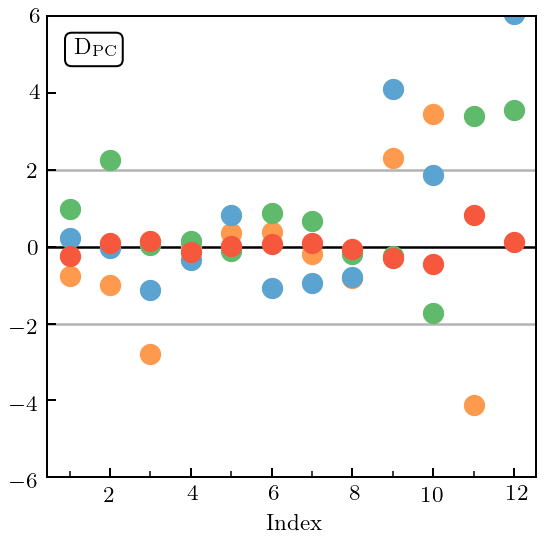

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.99370492]
  [  4.764

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


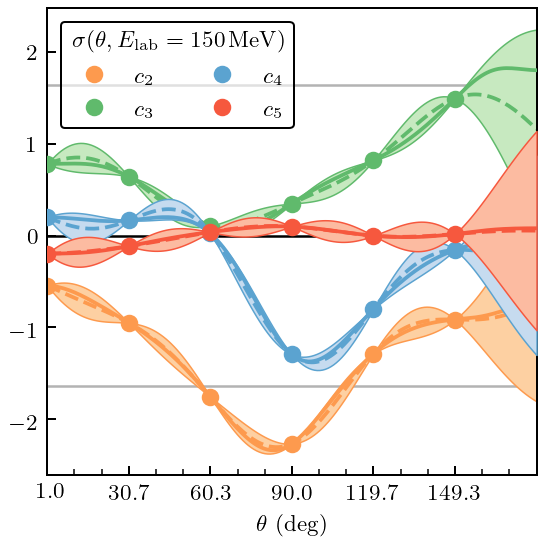

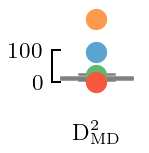

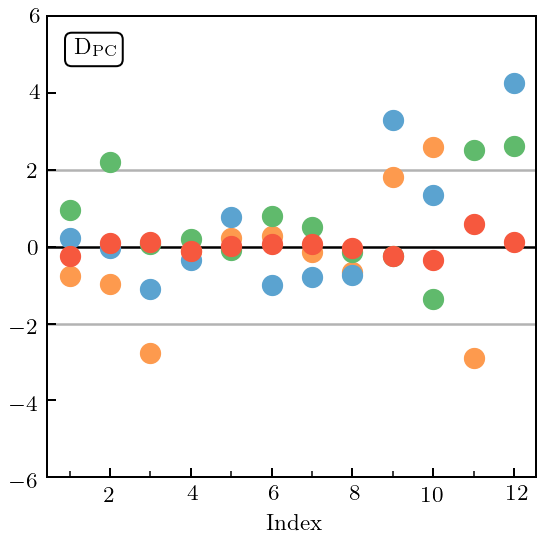

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.99370492]
  [  4.7648

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


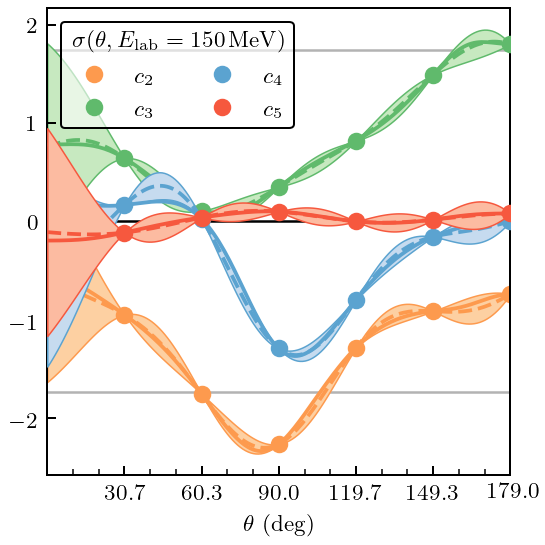

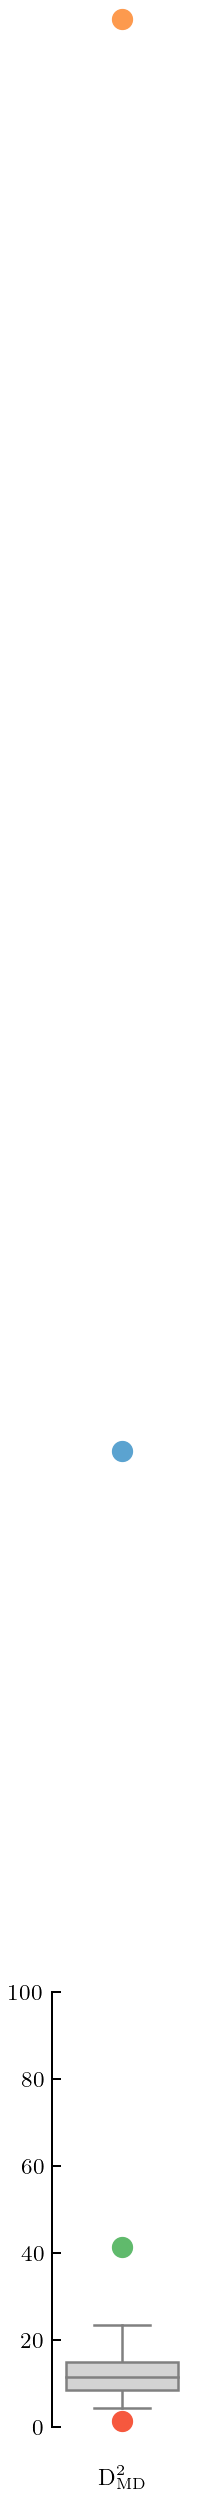

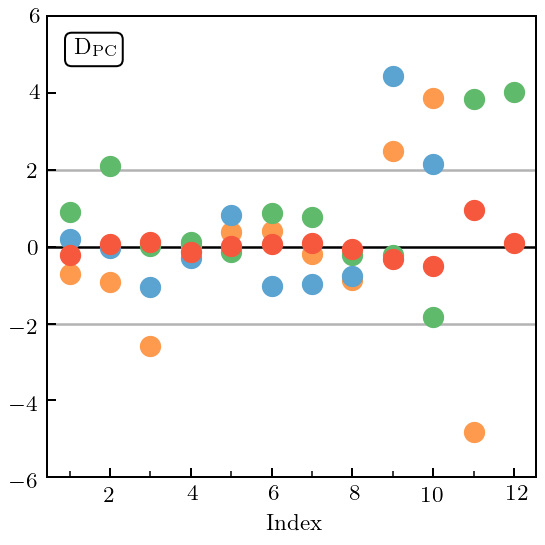

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     

test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.9

test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.9

test first: 4.629848587659999 33.84641810851793
test last: 530.5280999631028 501.3115304422448
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.9937

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


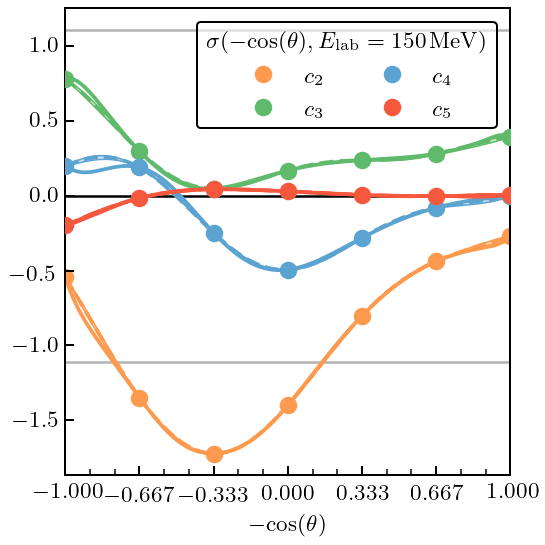

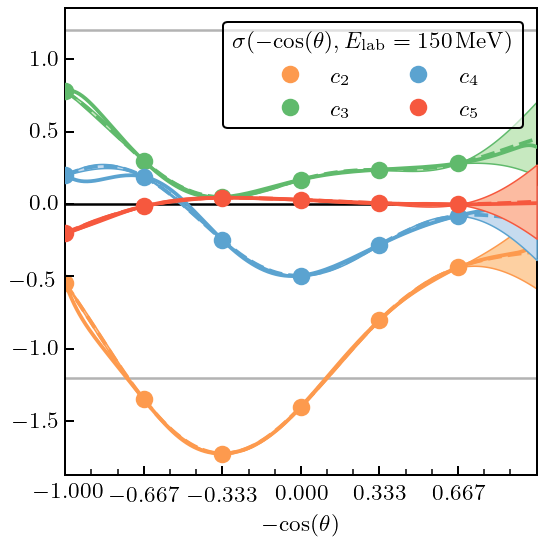

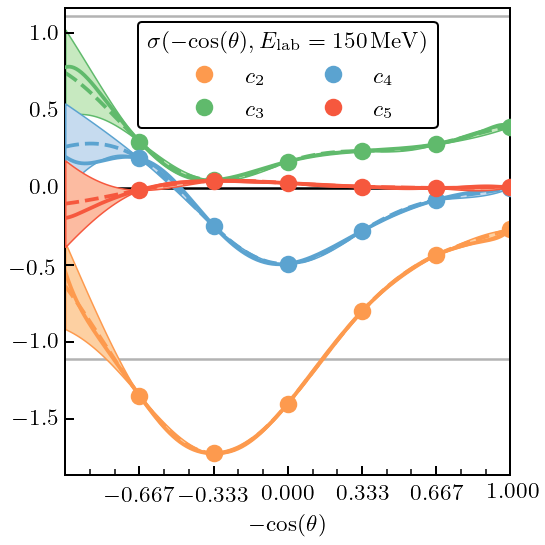

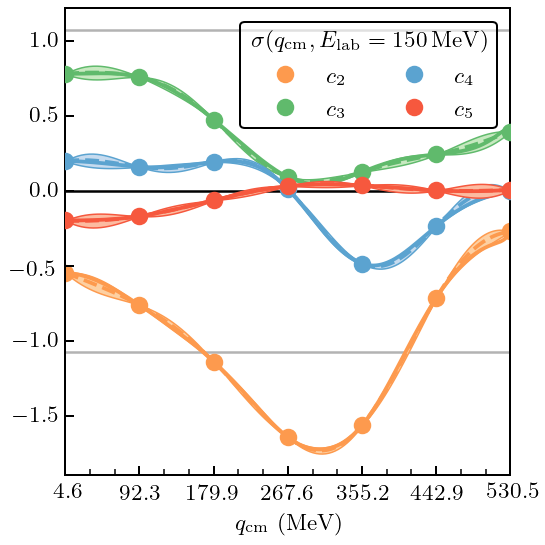

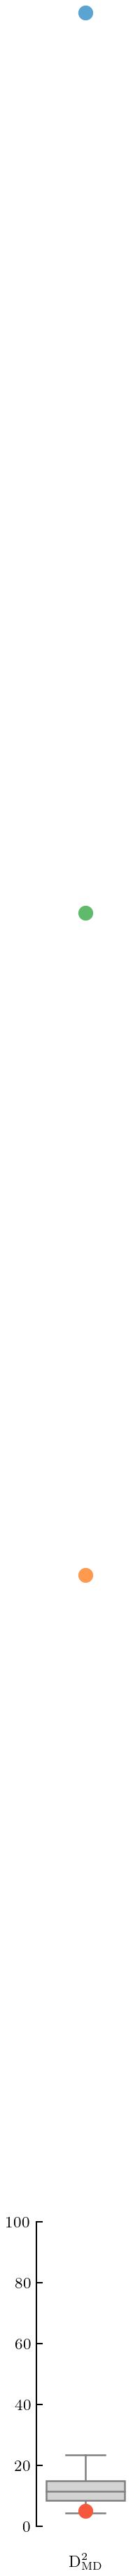

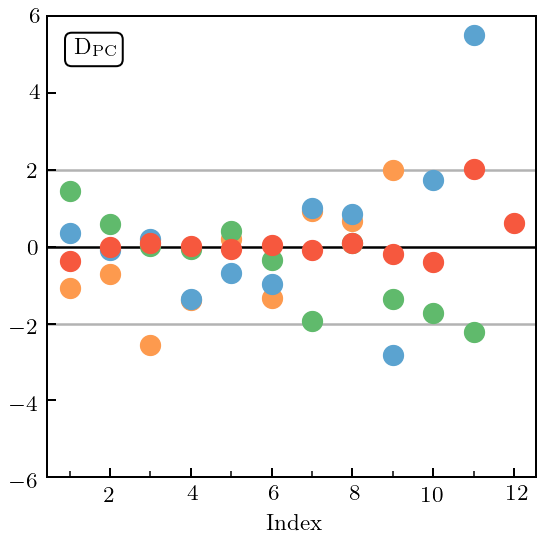

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 4.629848587659999 33.84641810851793
test last: 530.5280999631028 530.5280999631028
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.9621999

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


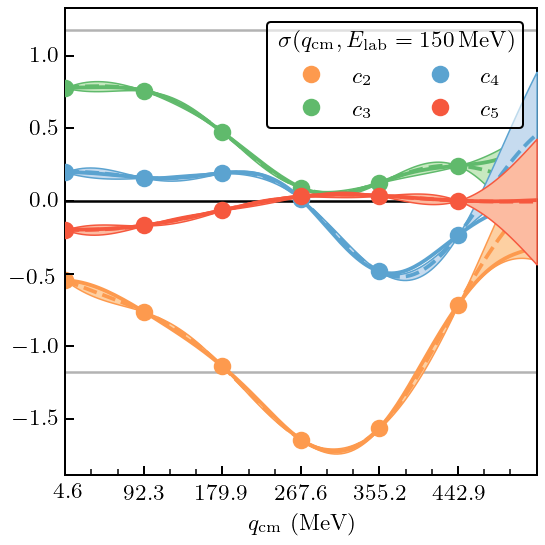

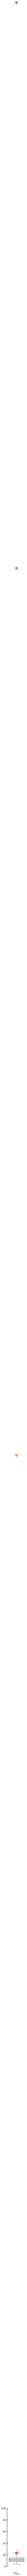

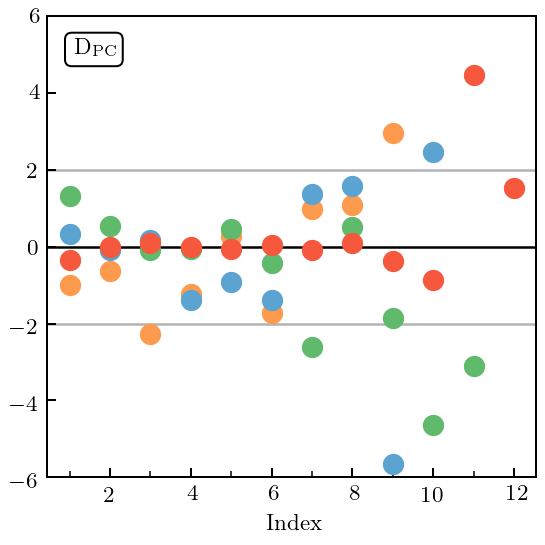

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 4.629848587659999 4.629848587659999
test last: 530.5280999631028 501.3115304422448
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.9621999

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


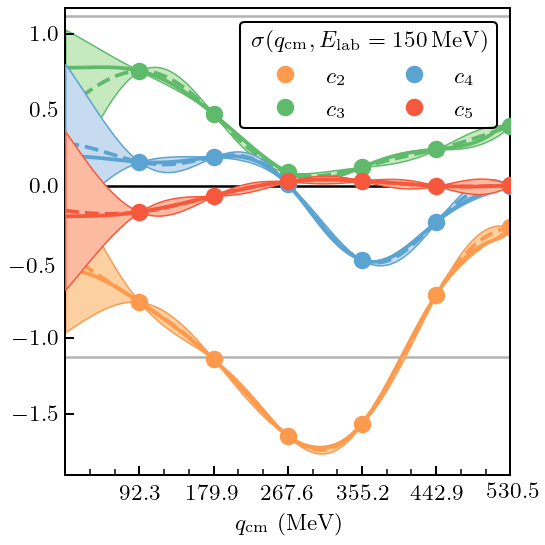

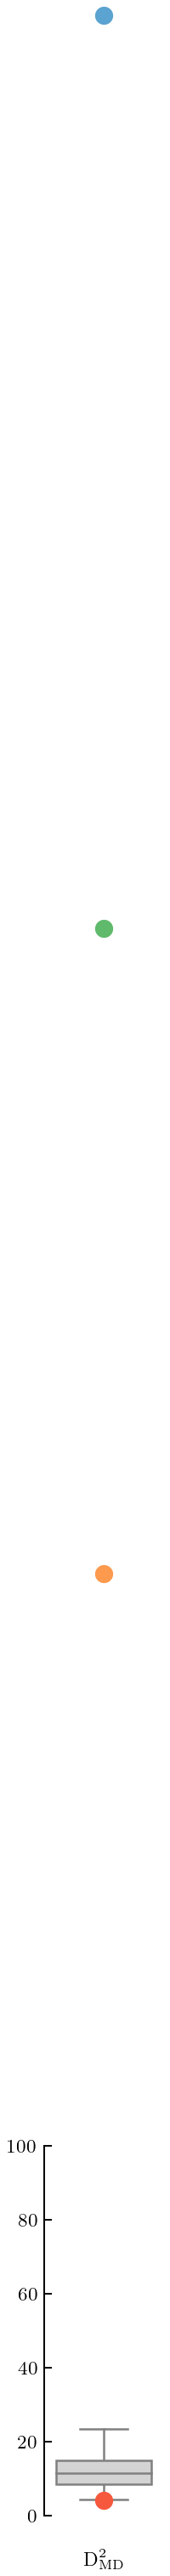

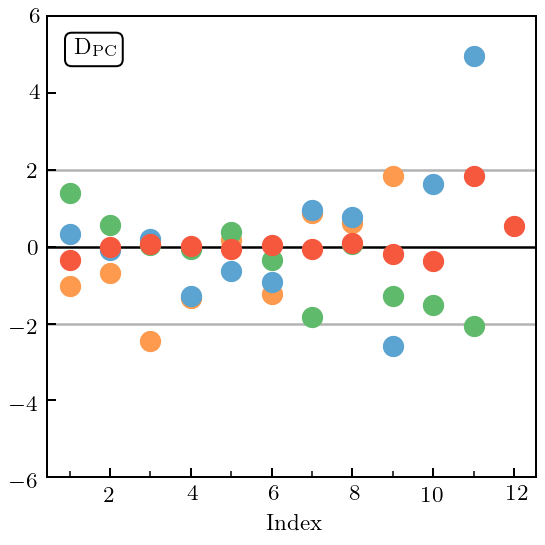

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 21.435497944657286 15656.914906417735
test last: 281460.06485046004 265824.585441987
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219992   2.98155472
     2.99

test first: 21.435497944657286 15656.914906417735
test last: 281460.06485046004 281460.06485046004
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.962

test first: 21.435497944657286 21.435497944657286
test last: 281460.06485046004 265824.585441987
(5, 350, 13)
(5, 350, 12)
data = [[[336.27353246 336.27417438 336.27524402 ... 339.0451516  339.04620386
   339.04683534]
  [228.70961987 228.71036091 228.71159567 ... 231.83984758 231.84104176
   231.84175844]
  [179.52182049 179.52262879 179.52397559 ... 182.93016913 182.93152228
   182.93233439]
  ...
  [  2.43773363   2.4314377    2.42122056 ...   2.84588552   2.88204304
     2.90442562]
  [  2.4226504    2.41640285   2.40626497 ...   2.8252405    2.86117399
     2.88341941]
  [  2.40764316   2.40144386   2.39138504 ...   2.80470724   2.84041694
     2.86252533]]

 [[337.73746402 337.73815251 337.73929974 ... 340.68835403 340.68946609
   340.69013346]
  [230.42307384 230.42391466 230.42531566 ... 233.93041551 233.93173777
   233.93253129]
  [180.71971572 180.72067138 180.72226368 ... 184.69041927 184.69197757
   184.6929128 ]
  ...
  [  4.76546348   4.75534335   4.73880092 ...   2.96219

test first: 1 10.88888888888889
test last: 179 169.11111111111111
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
    0.36888825]


C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


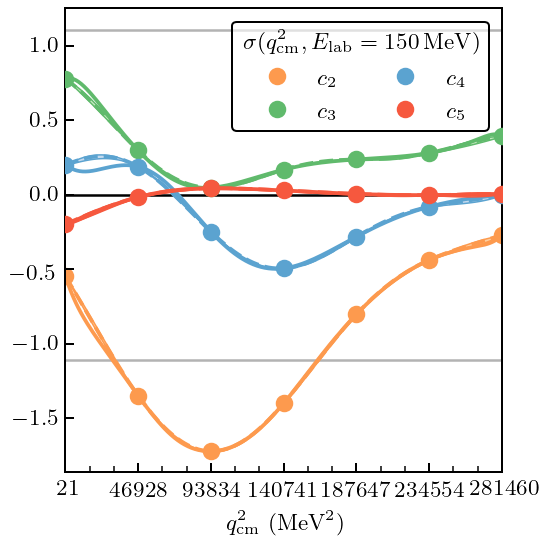

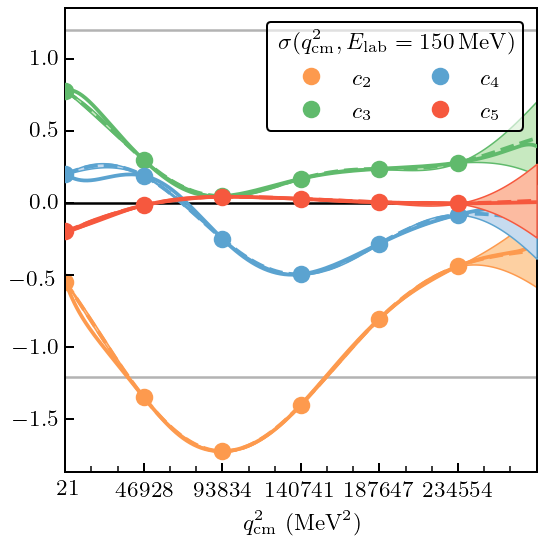

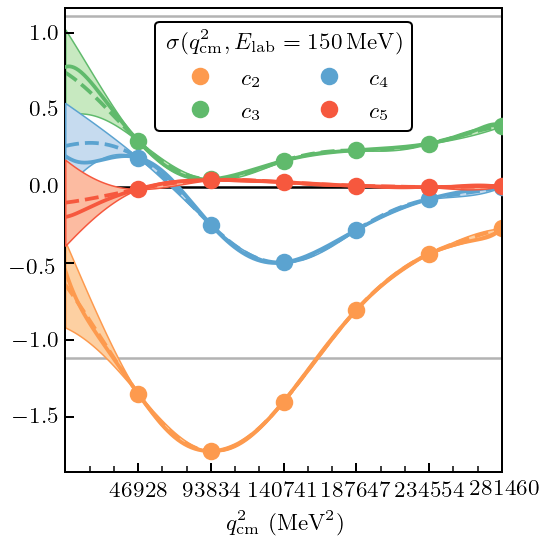

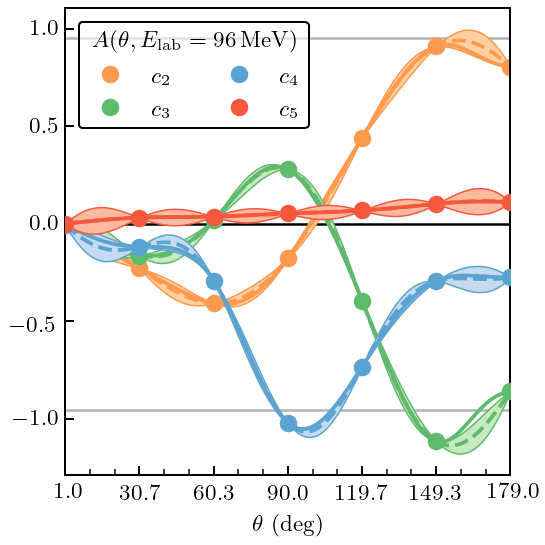

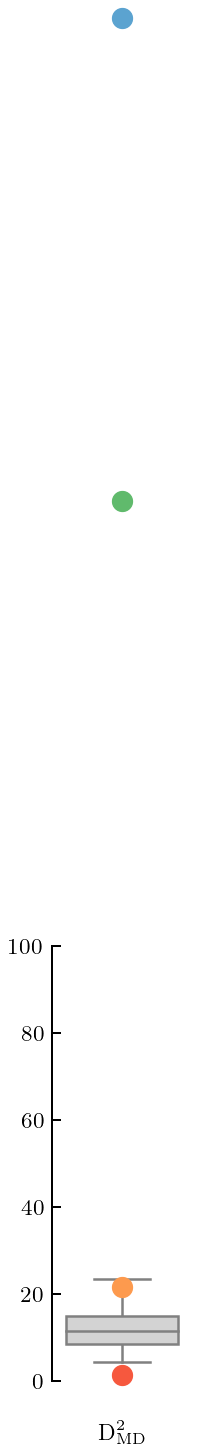

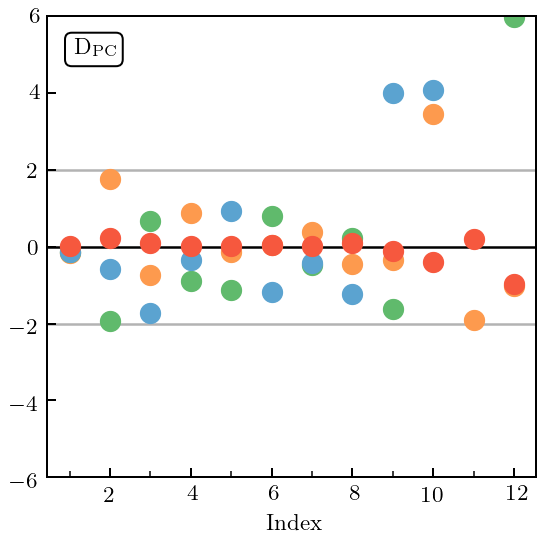

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
   

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


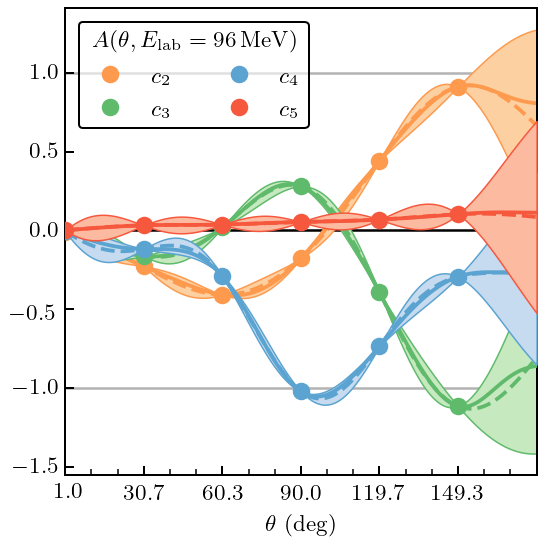

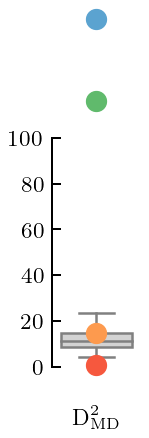

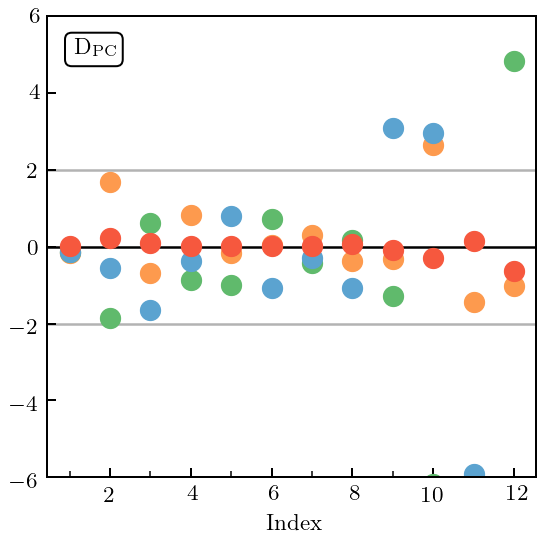

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
    

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


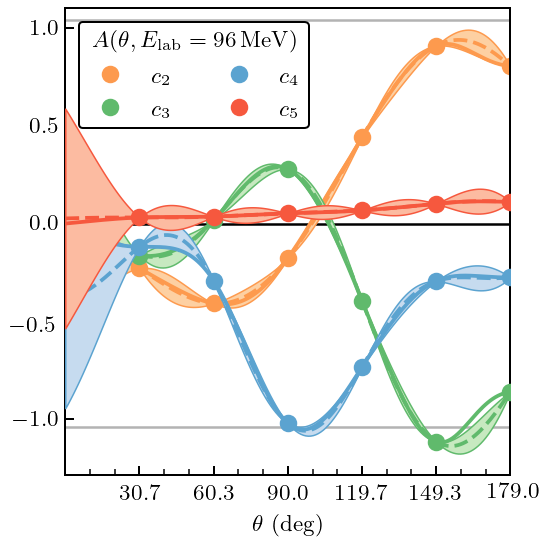

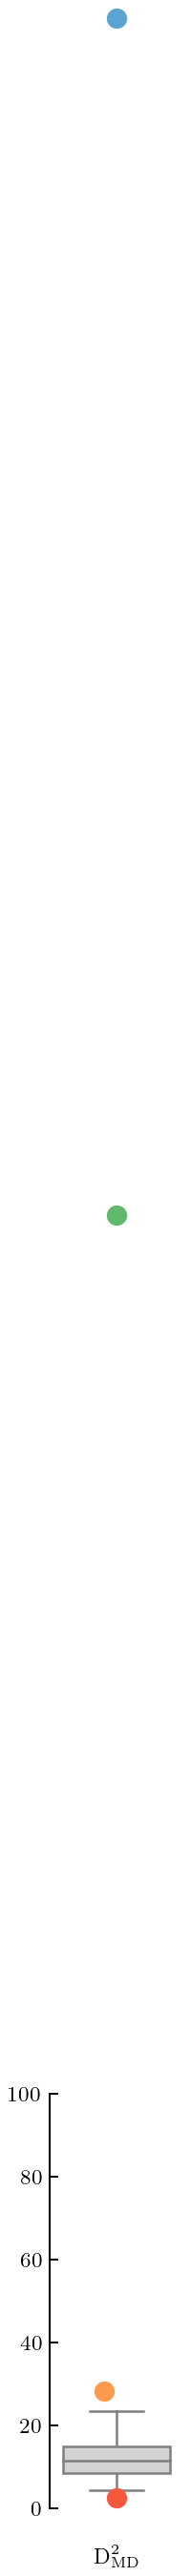

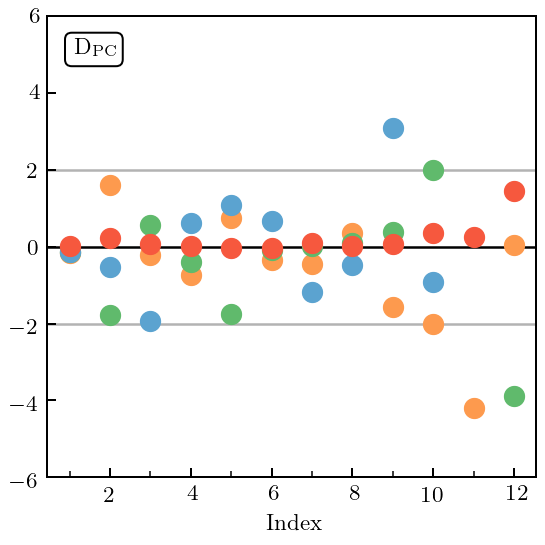

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


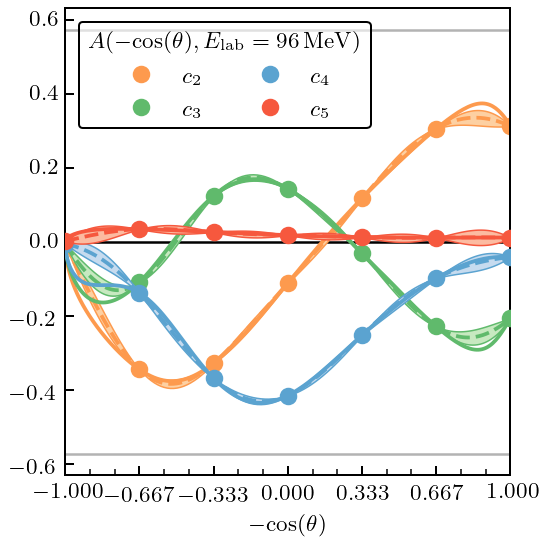

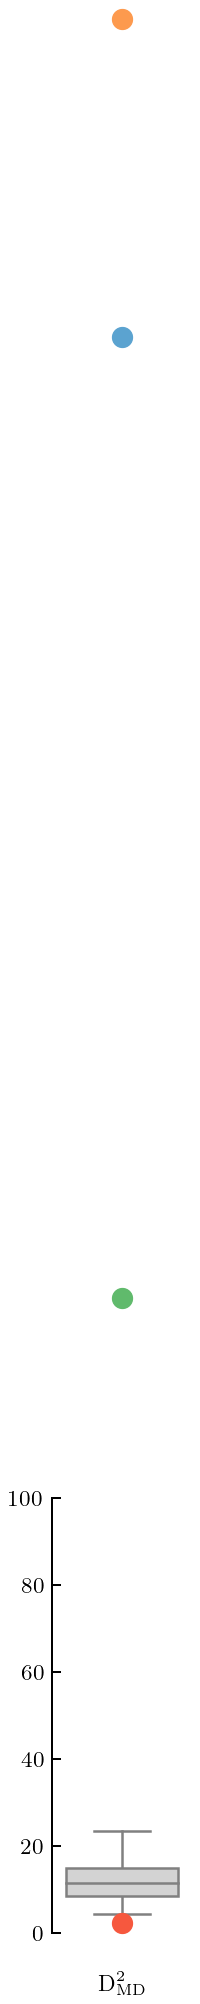

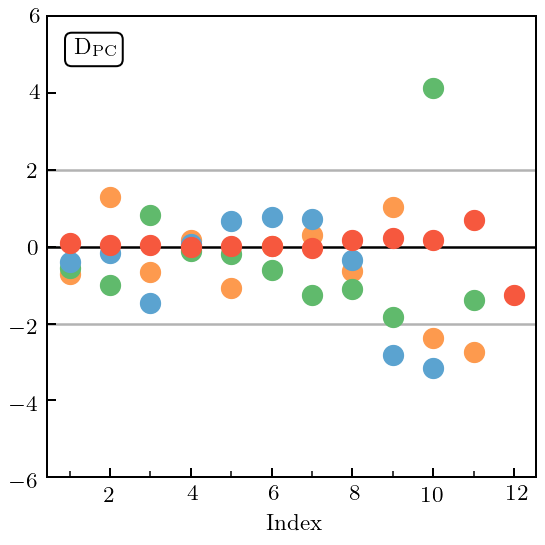

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


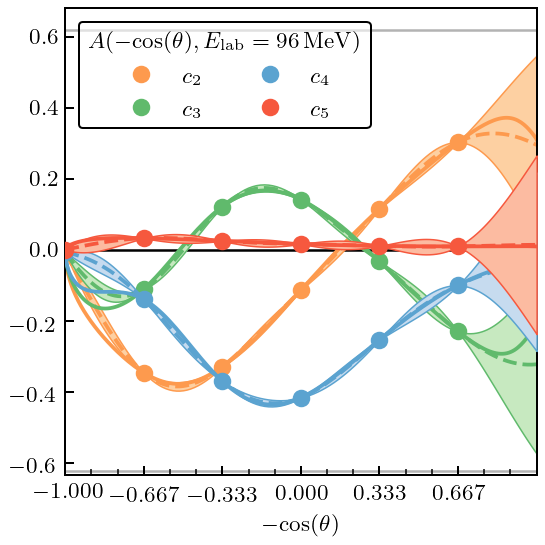

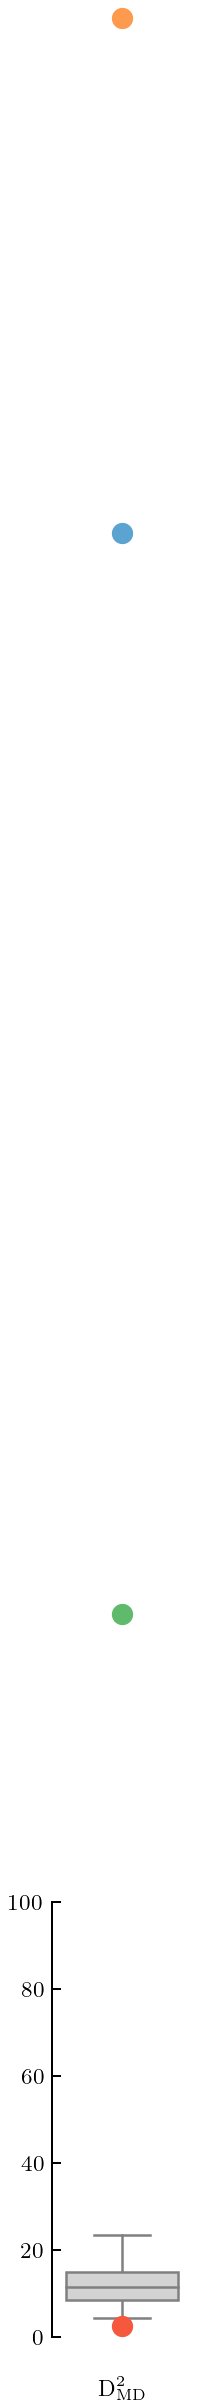

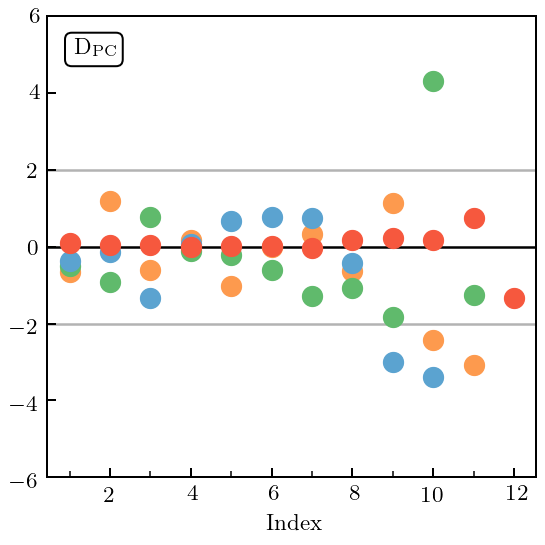

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


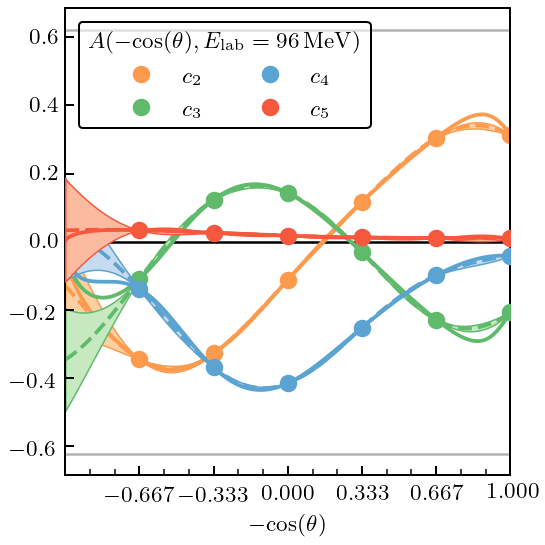

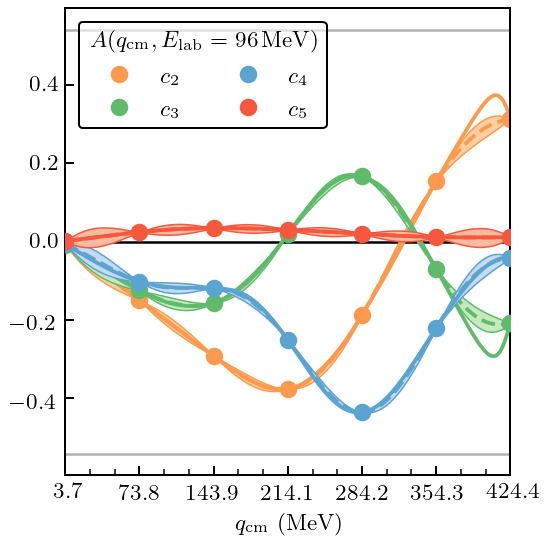

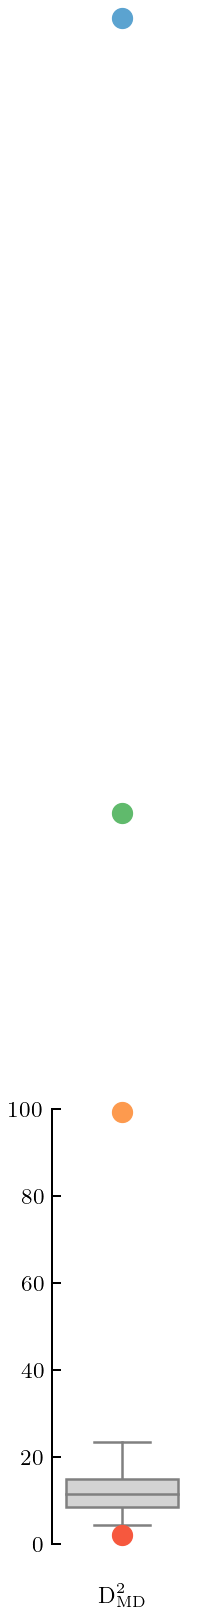

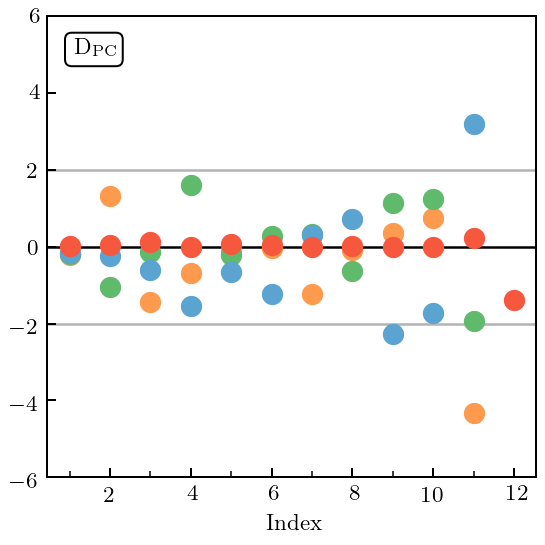

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 3.703878847885973 27.077134324214448
test last: 424.4224774217985 424.4224774217985
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126 

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


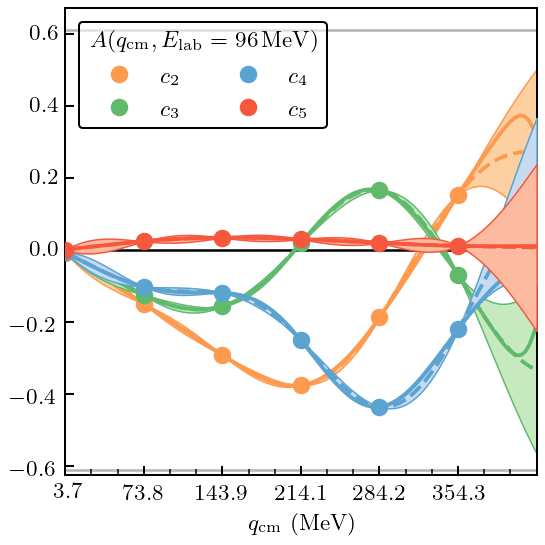

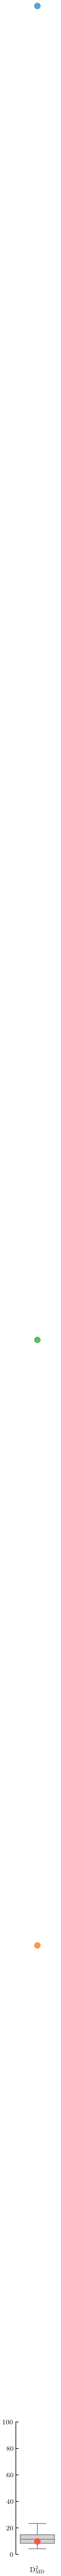

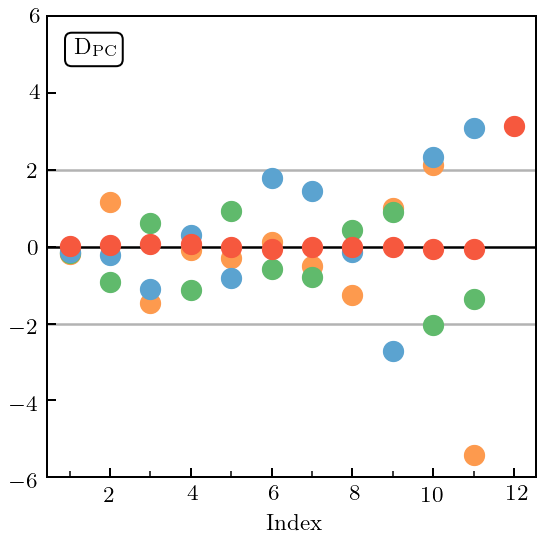

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 3.703878847885973 3.703878847885973
test last: 424.4224774217985 401.04922194547004
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126 

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


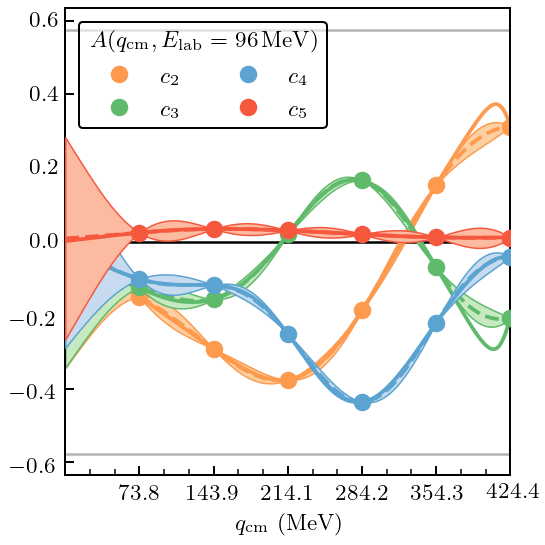

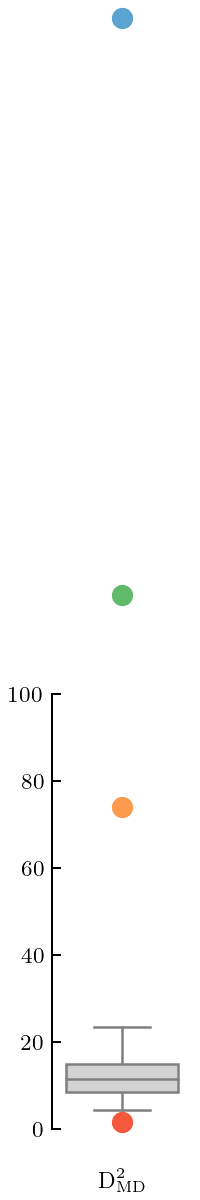

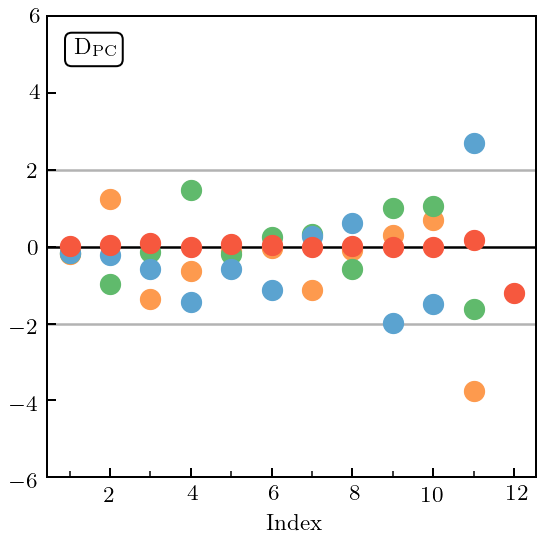

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 10020.425419760773
test last: 180134.43934085703 170127.7326396161
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


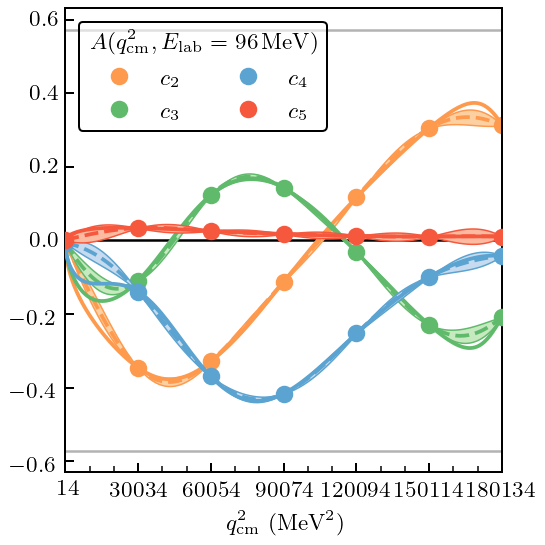

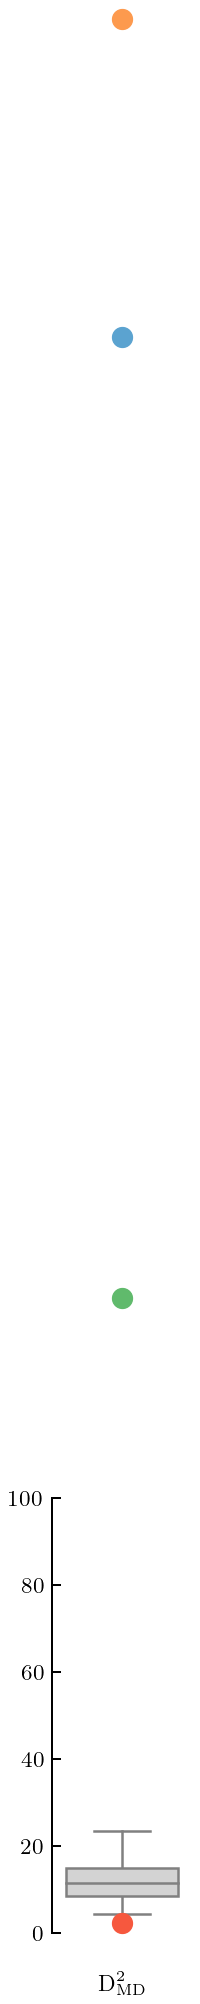

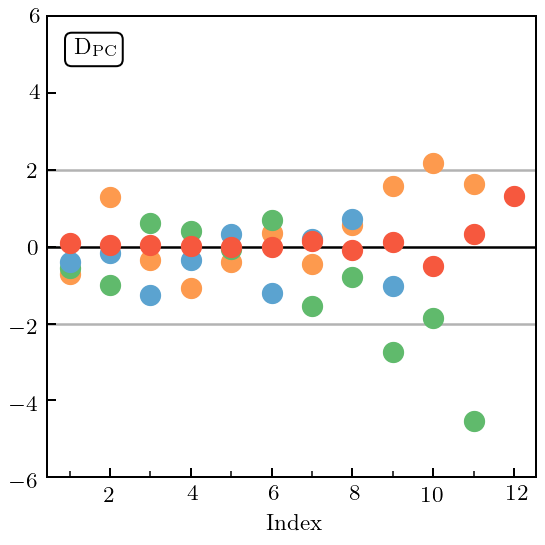

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 10020.425419760773
test last: 180134.43934085703 180134.43934085703
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.013911

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


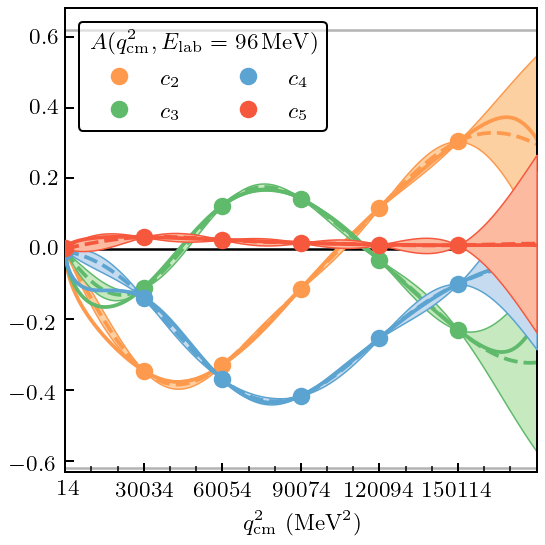

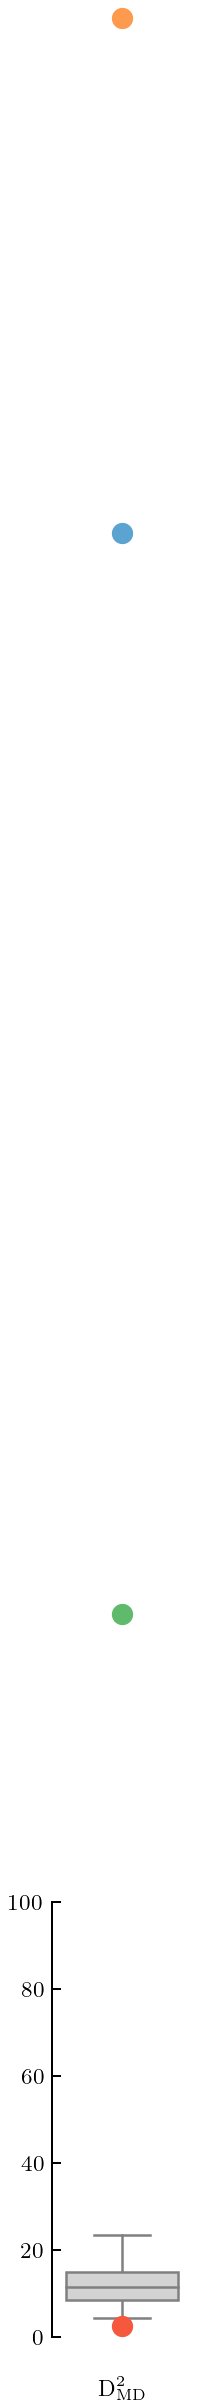

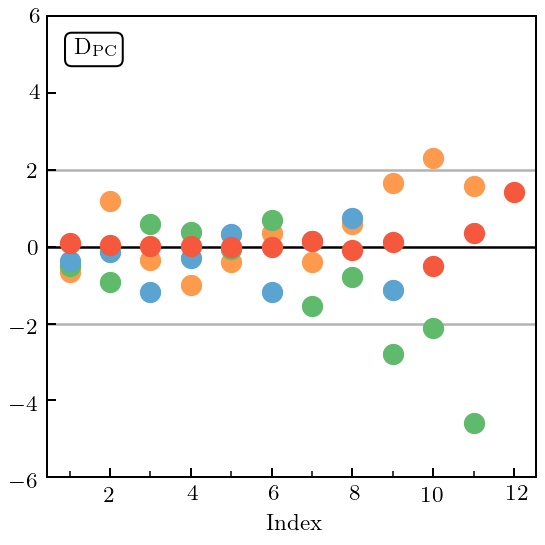

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 13.718718519817124 13.718718519817124
test last: 180134.43934085703 170127.7326396161
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139112

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


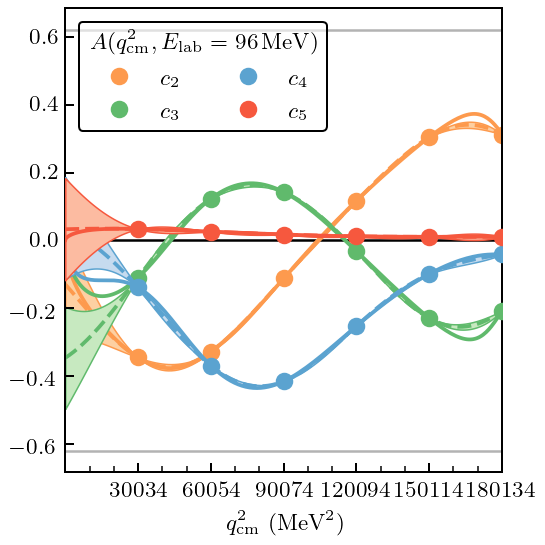

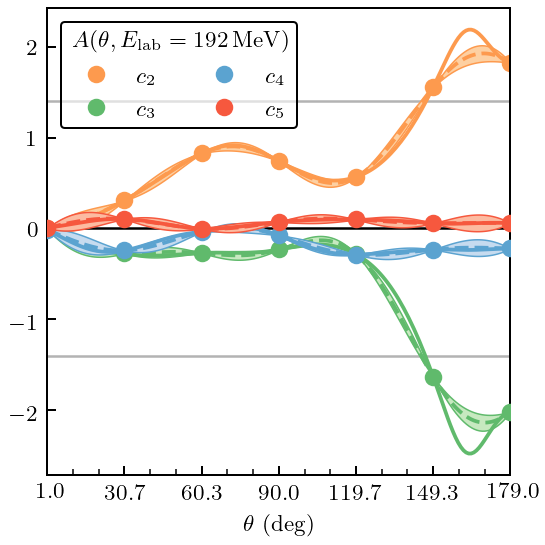

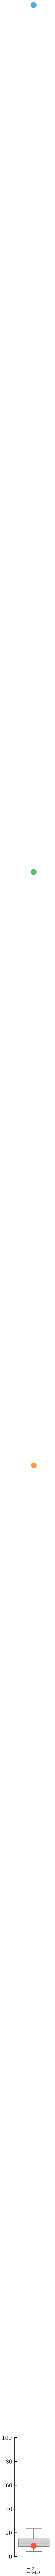

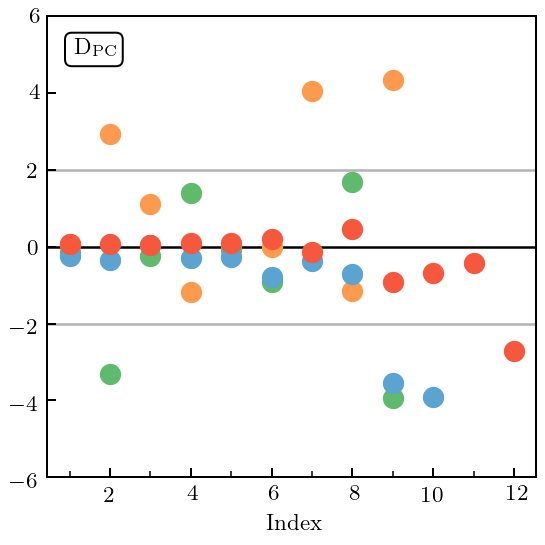

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
   

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


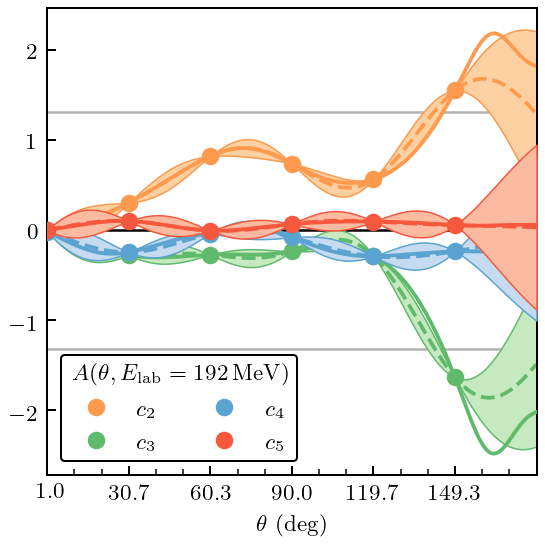

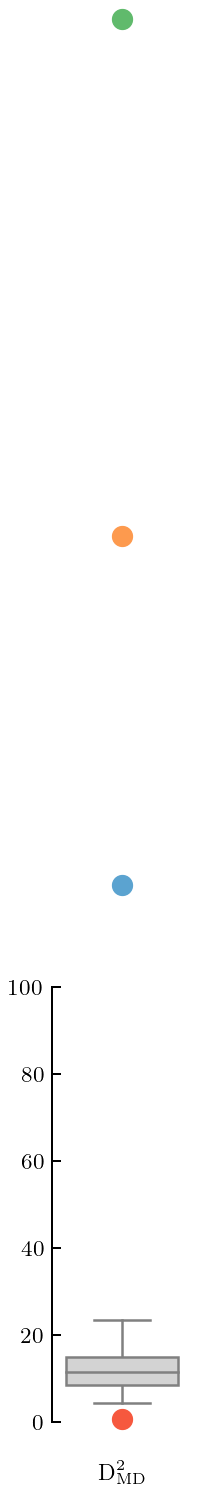

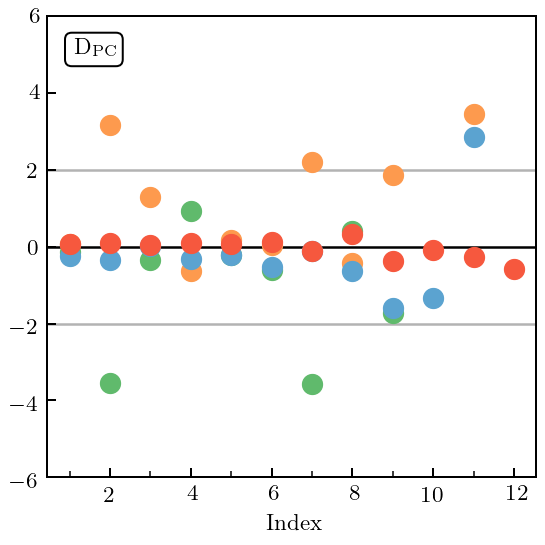

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
    

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


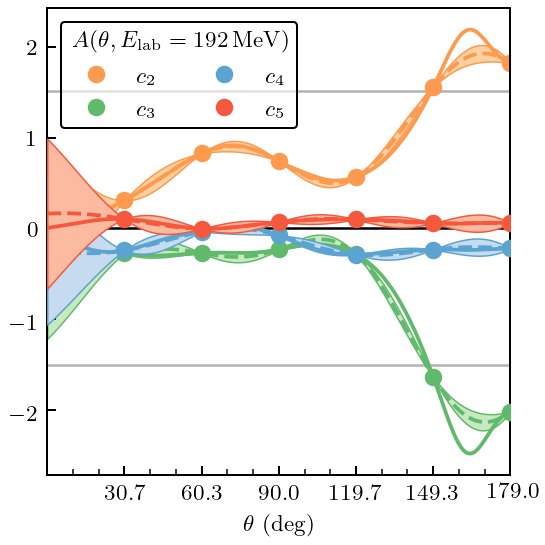

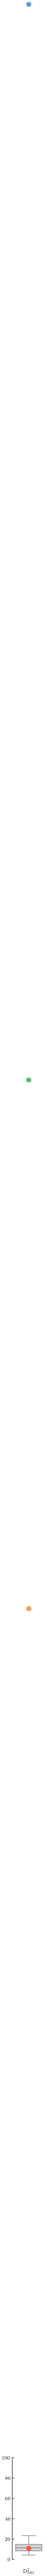

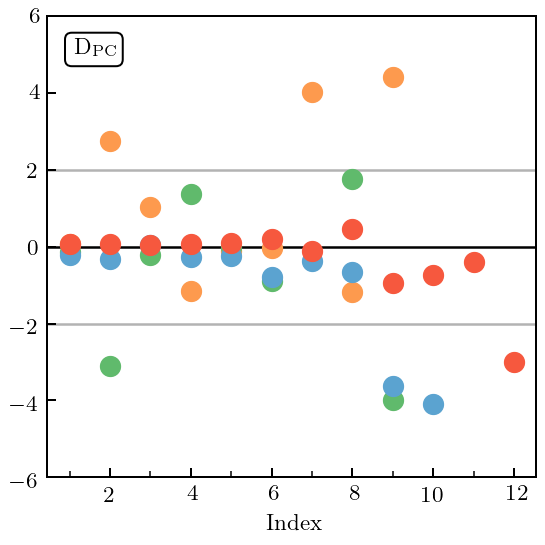

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


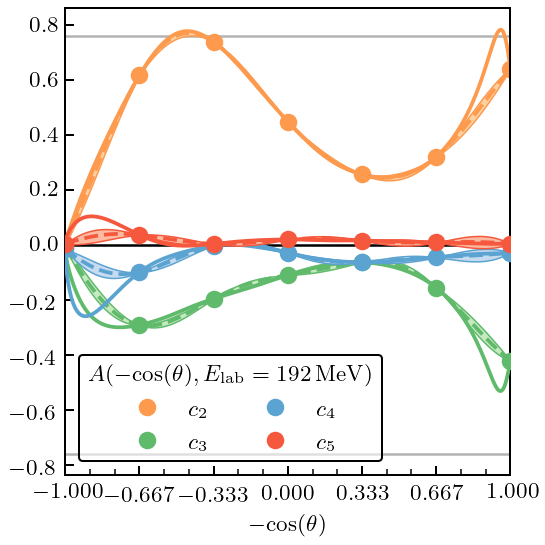

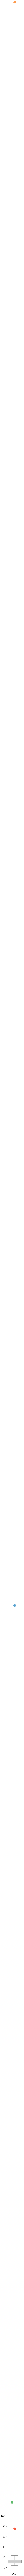

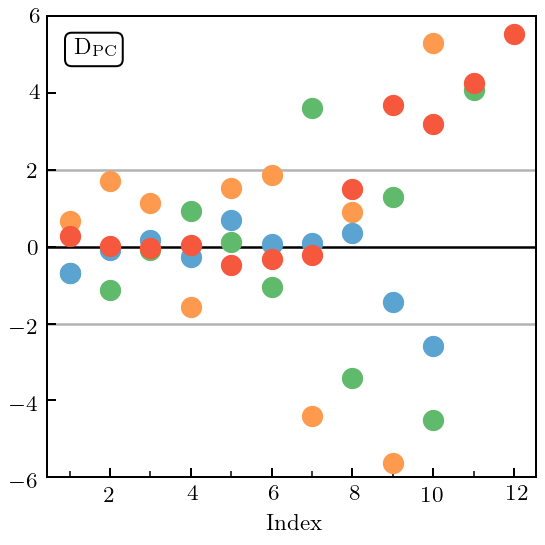

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


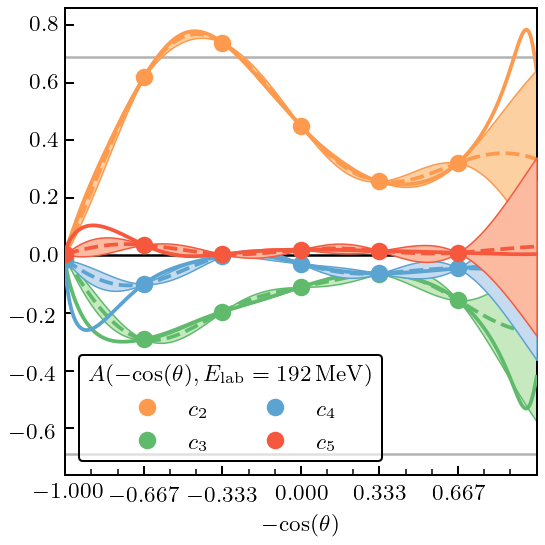

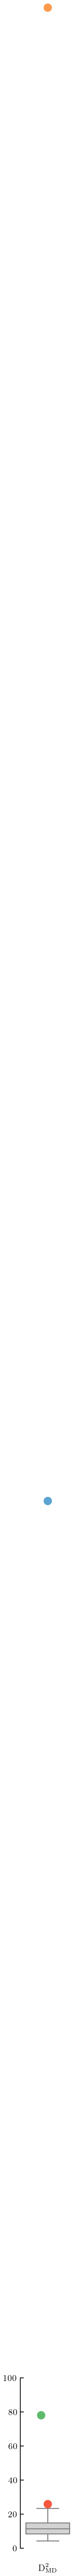

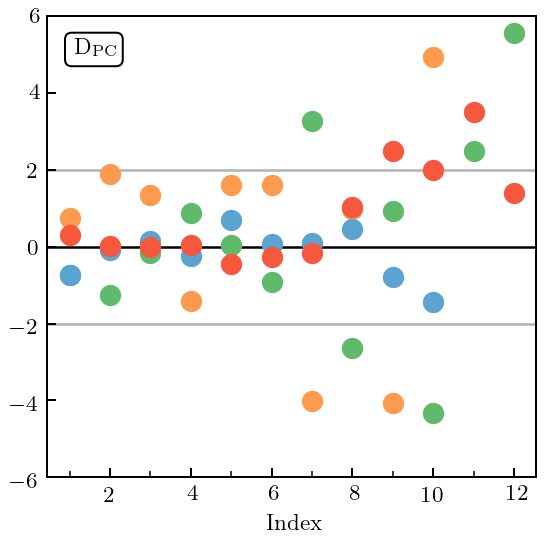

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


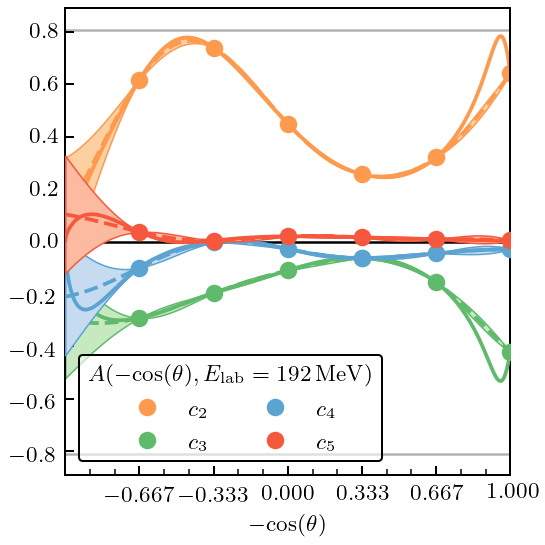

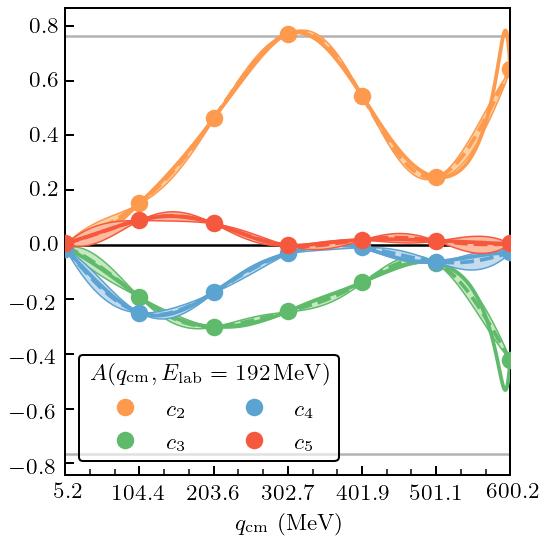

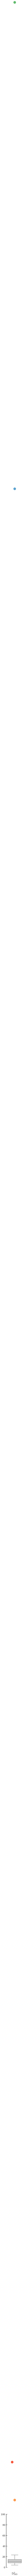

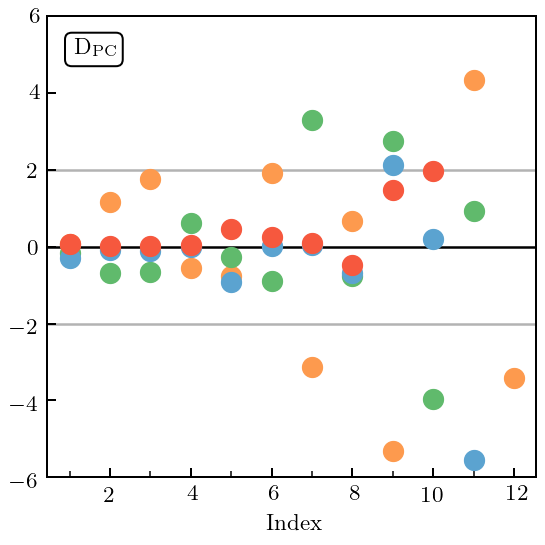

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 5.238075754853146 38.29285099201387
test last: 600.2240300237463 600.2240300237463
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


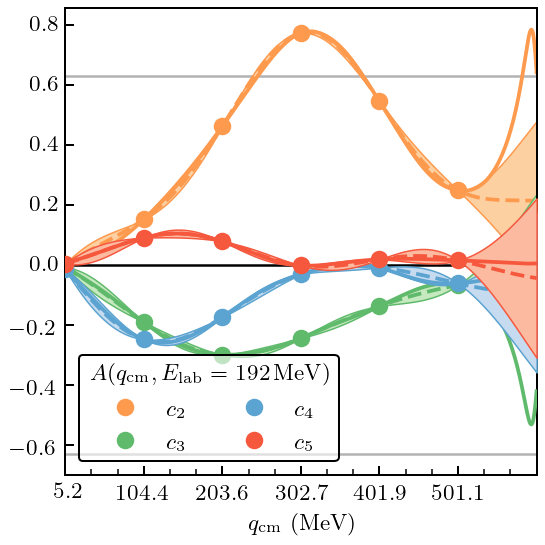

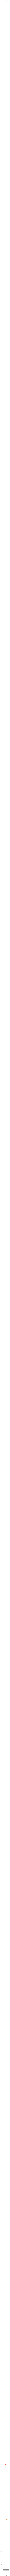

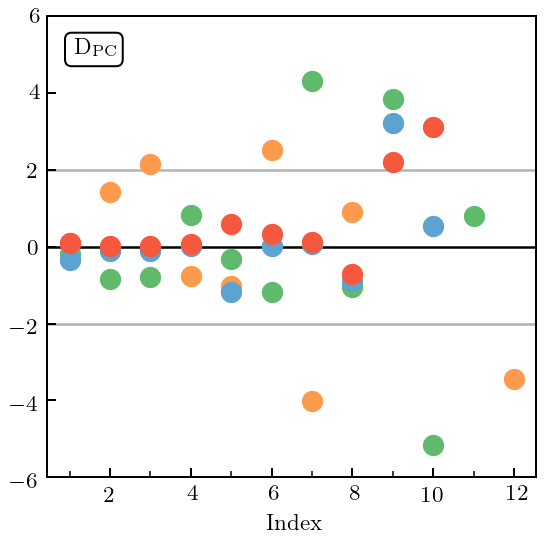

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 5.238075754853146 5.238075754853146
test last: 600.2240300237463 567.1692547865855
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


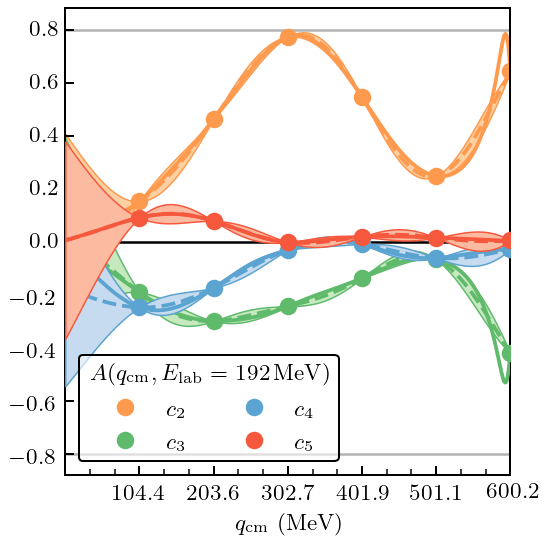

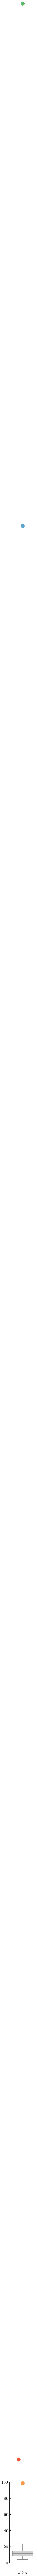

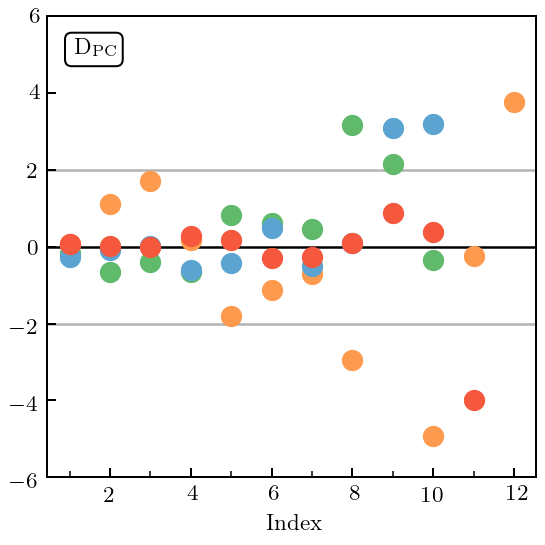

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 20040.851258743223
test last: 360268.8862179471 340255.47239681747
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.378143

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


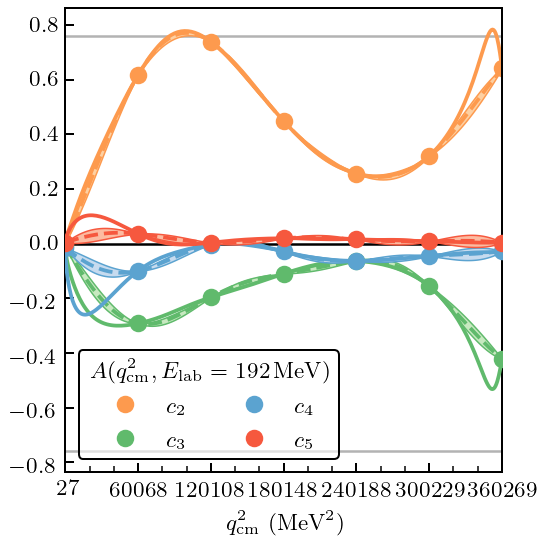

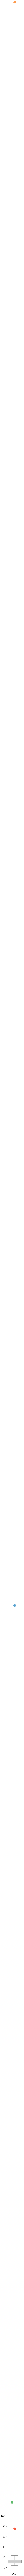

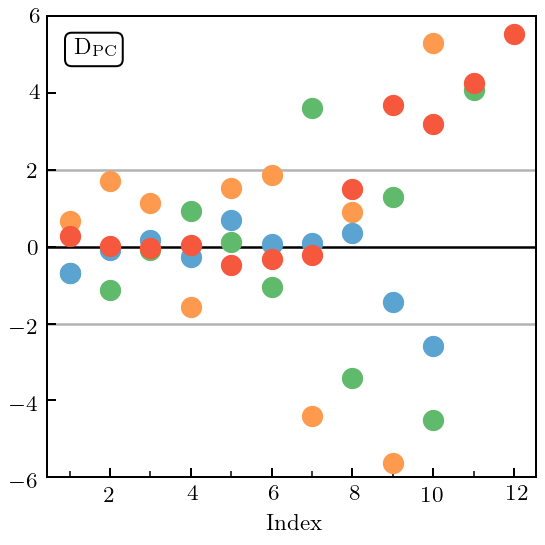

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 20040.851258743223
test last: 360268.8862179471 360268.8862179471
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126 

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


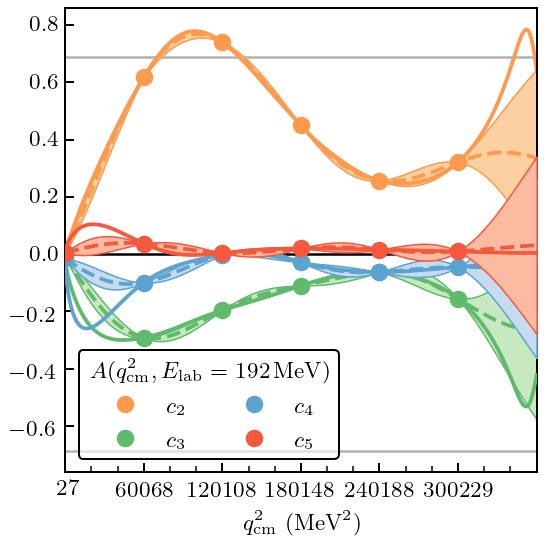

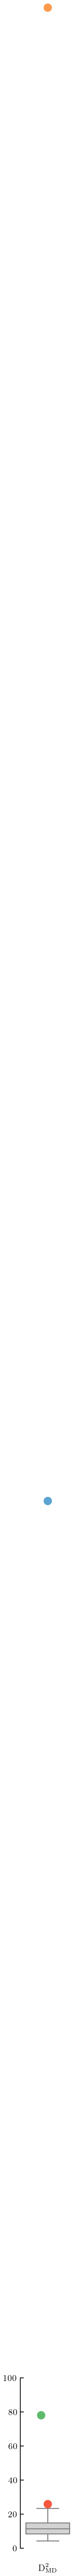

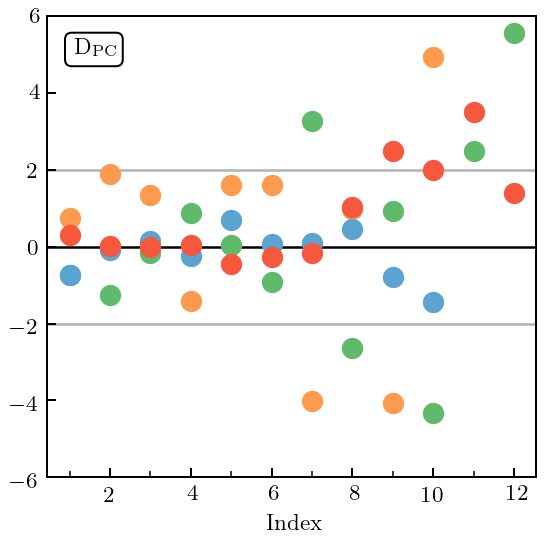

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 27.43743761358035 27.43743761358035
test last: 360268.8862179471 340255.47239681747
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126 

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


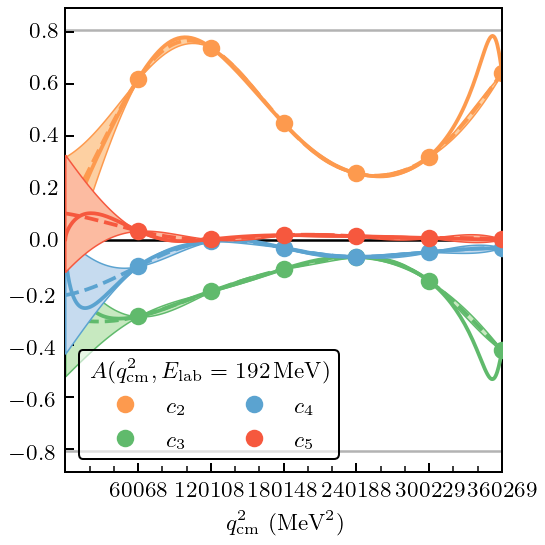

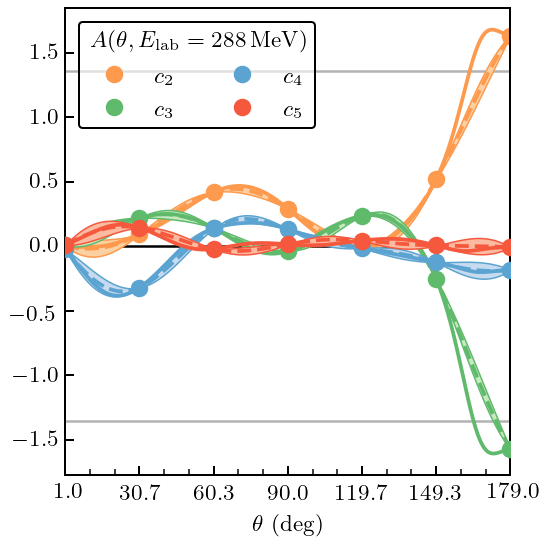

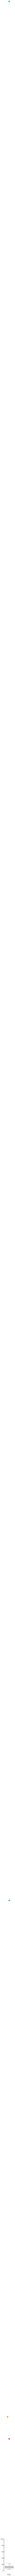

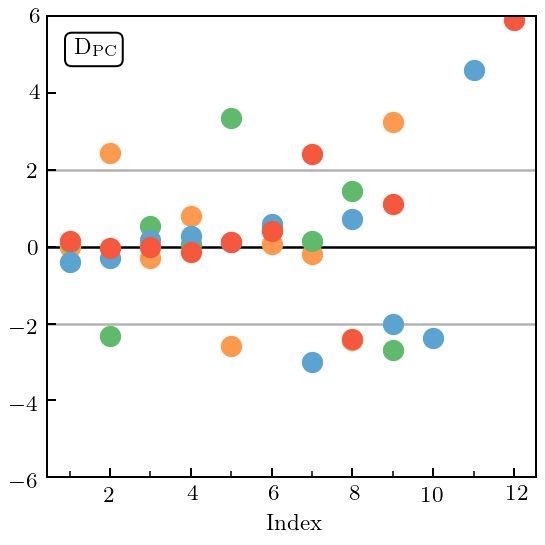

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 10.88888888888889
test last: 179 179.0
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
   

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


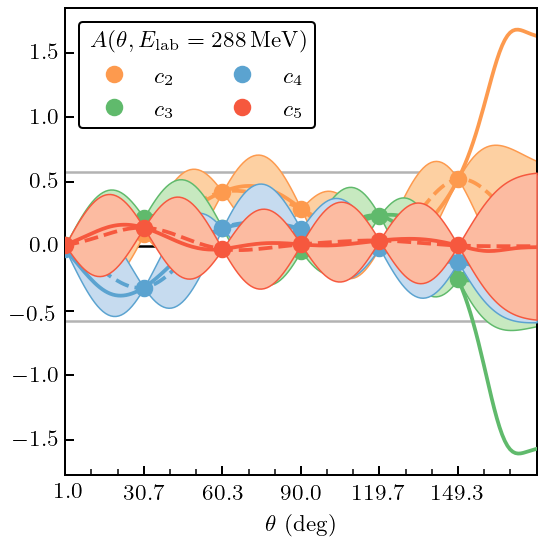

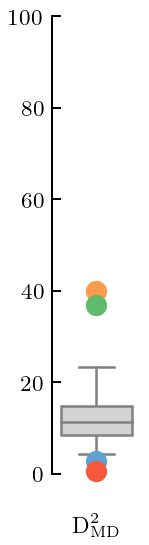

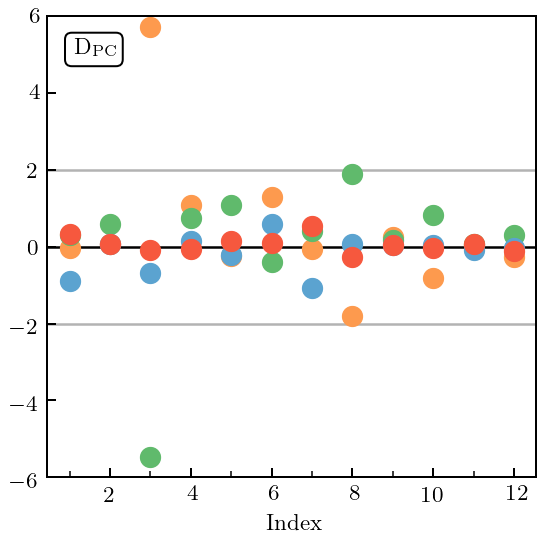

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 1 1.0
test last: 179 169.11111111111111
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353  0.37277326
    

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


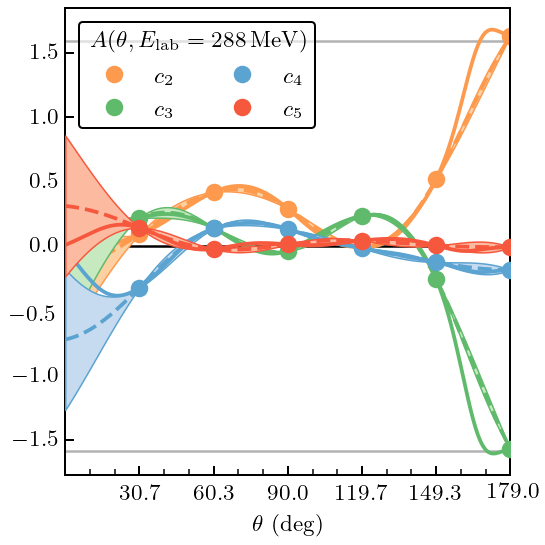

ValueError: Image size of 200x444450 pixels is too large. It must be less than 2^16 in each direction.

<Figure size 180x576 with 1 Axes>

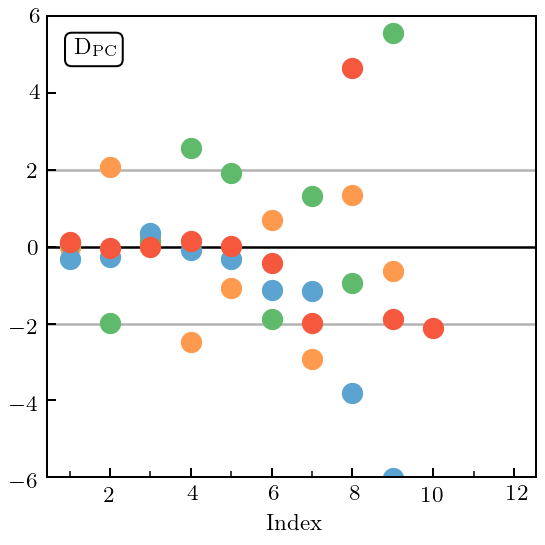

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.8887535068056811
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


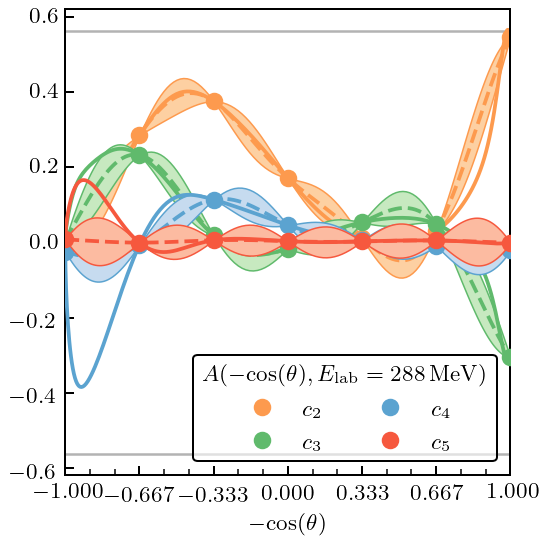

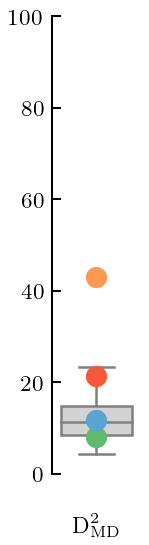

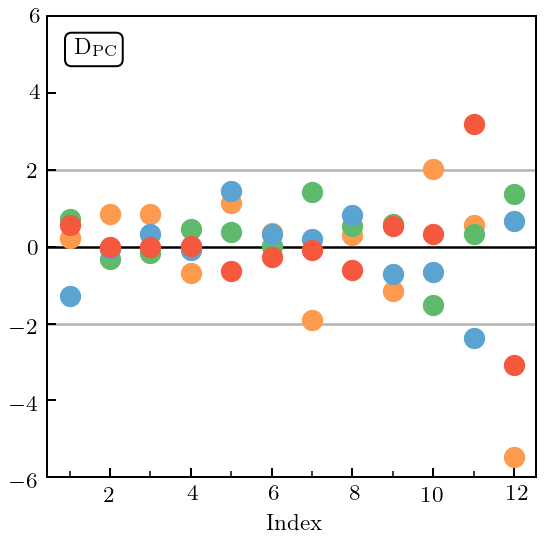

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.8887535068056811
test last: 0.9998476951563913 0.9998476951563913
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


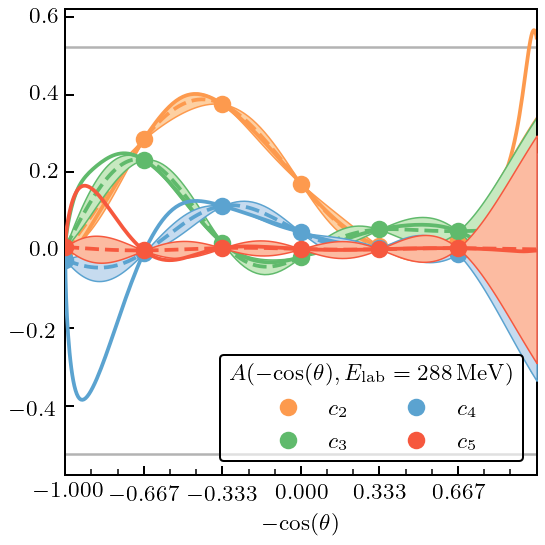

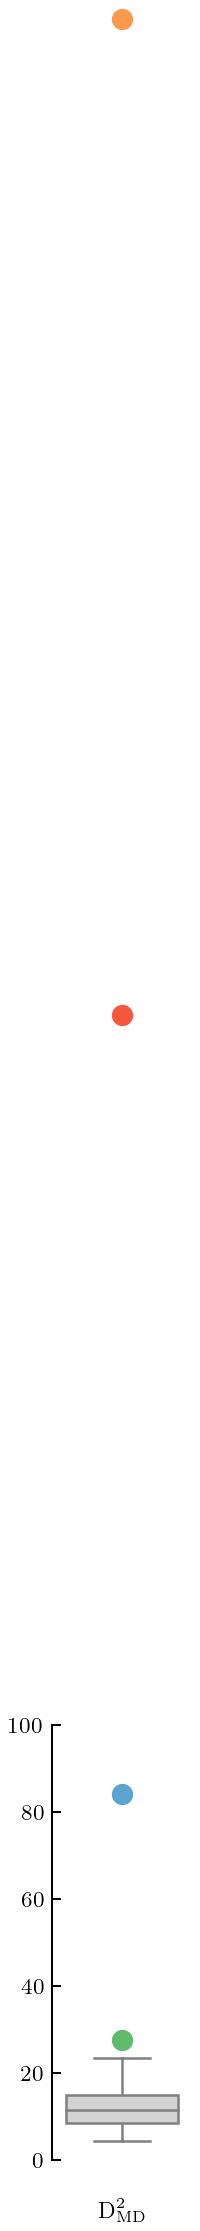

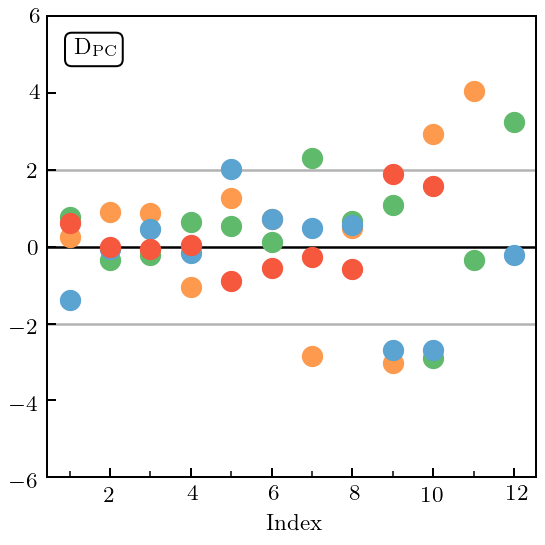

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: -0.9998476951563913 -0.9998476951563913
test last: 0.9998476951563913 0.8887535068056811
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.0139

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


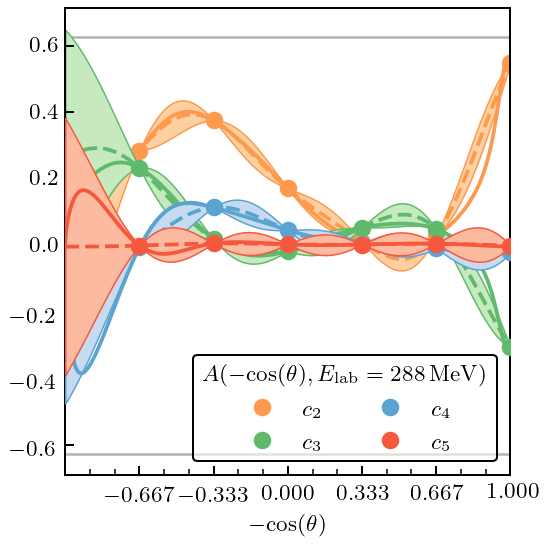

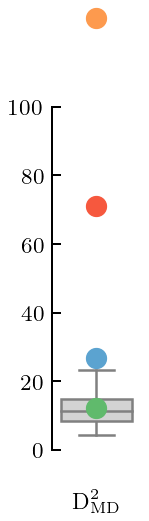

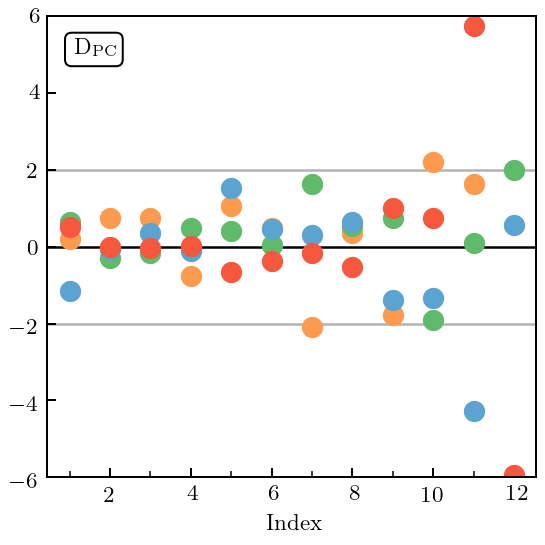

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 46.89897331049732
test last: 735.1213094651424 694.6376426325163
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.37814353

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


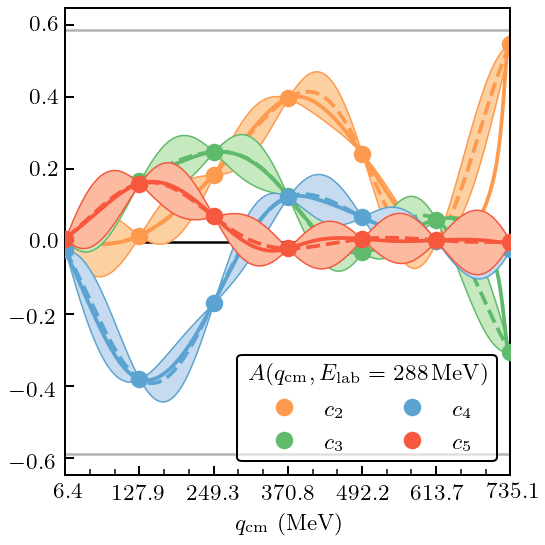

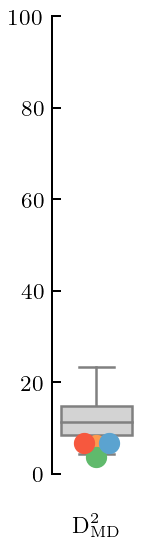

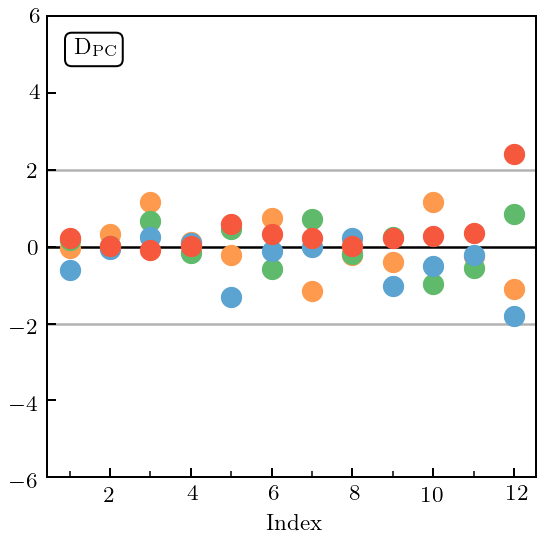

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 46.89897331049732
test last: 735.1213094651424 735.1213094651424
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


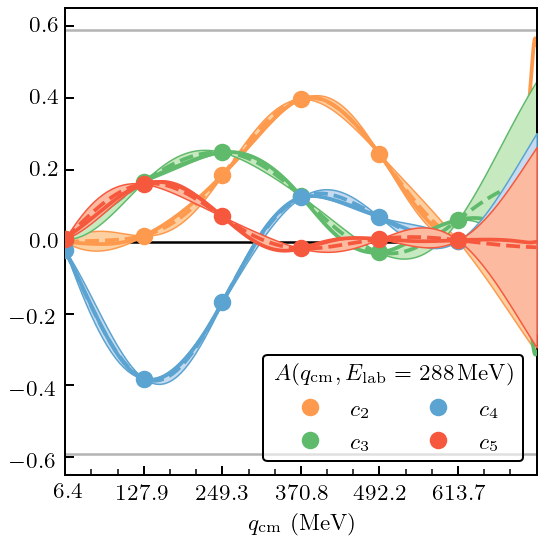

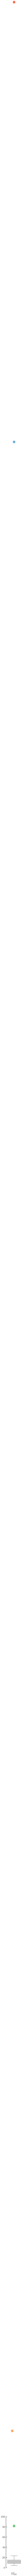

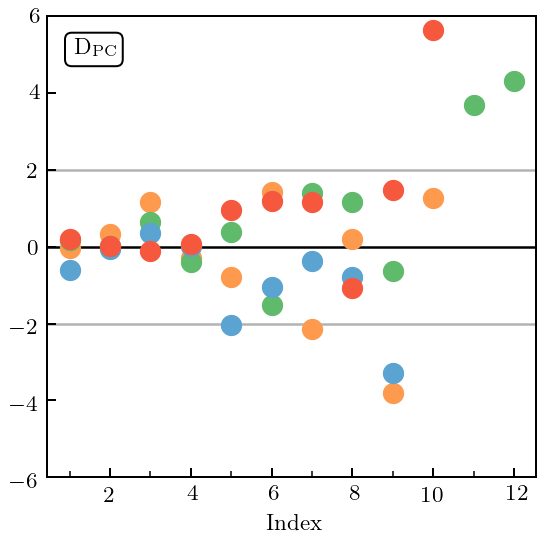

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 6.415306477871135 6.415306477871135
test last: 735.1213094651424 694.6376426325163
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


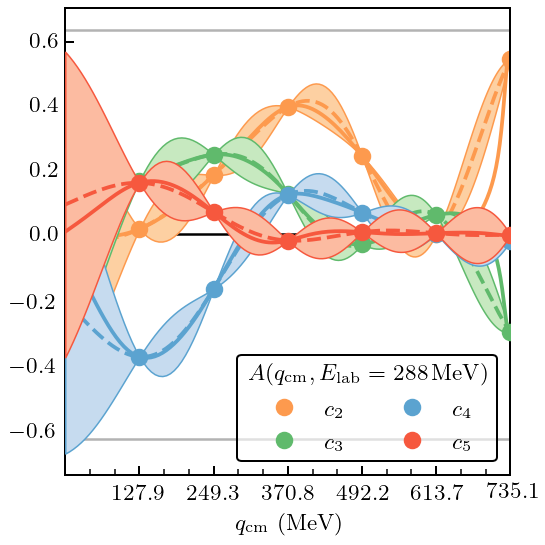

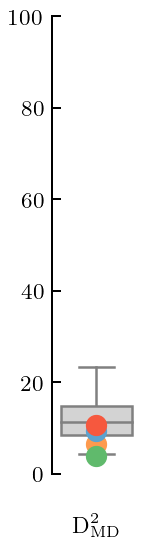

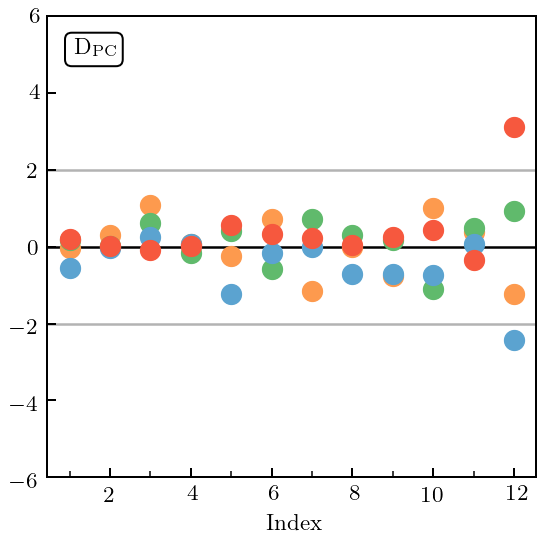

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 30061.277461235055
test last: 540403.3396297457 510383.2183257157
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  0.02099279 ...  0.3781435

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


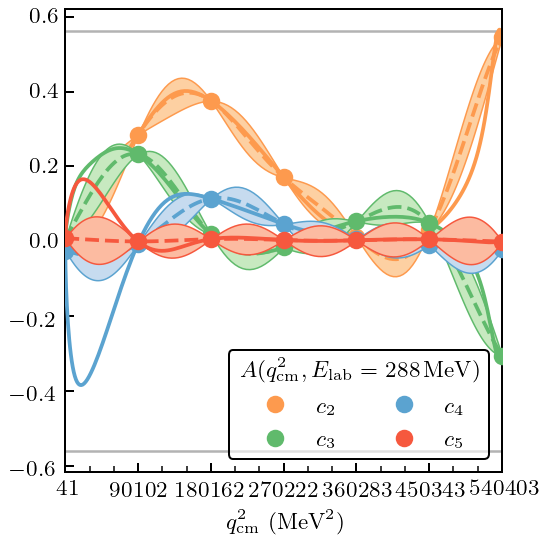

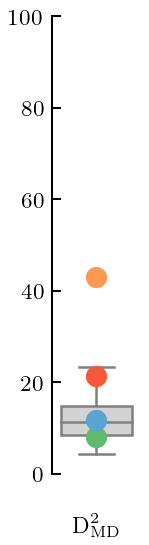

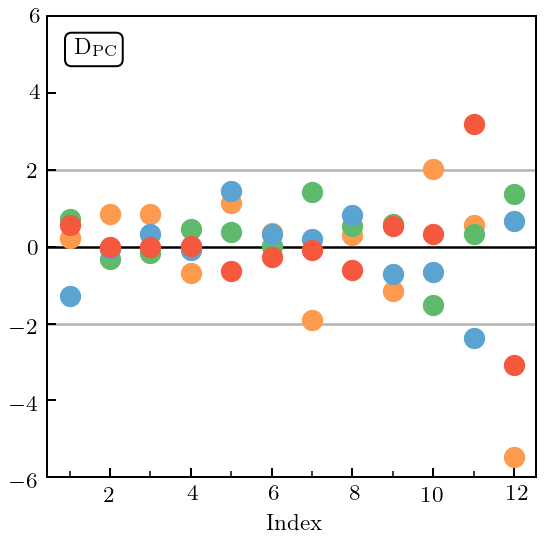

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 30061.277461235055
test last: 540403.3396297457 540403.3396297457
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126 

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:593: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


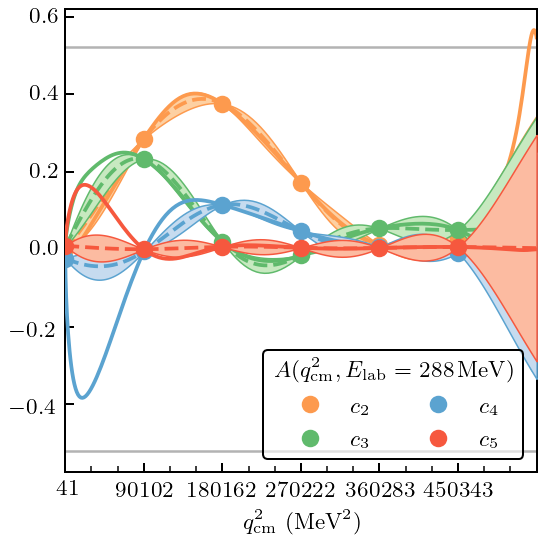

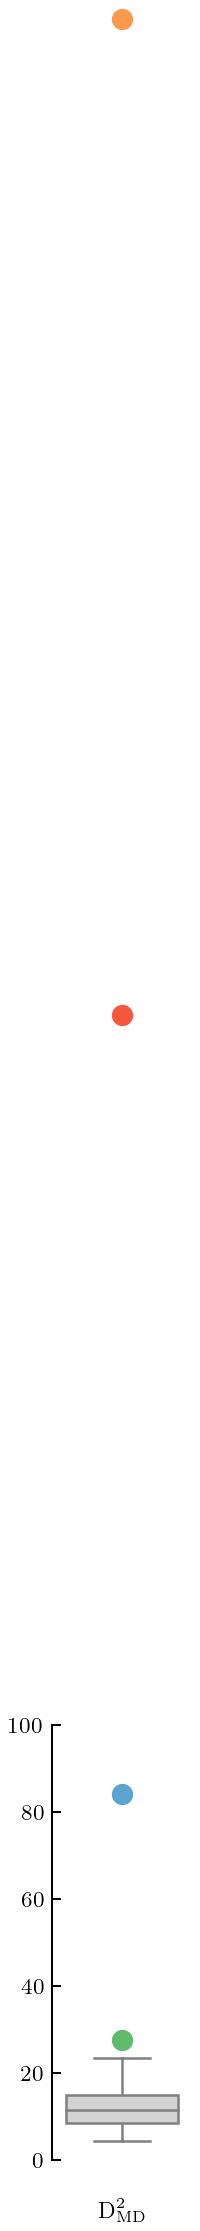

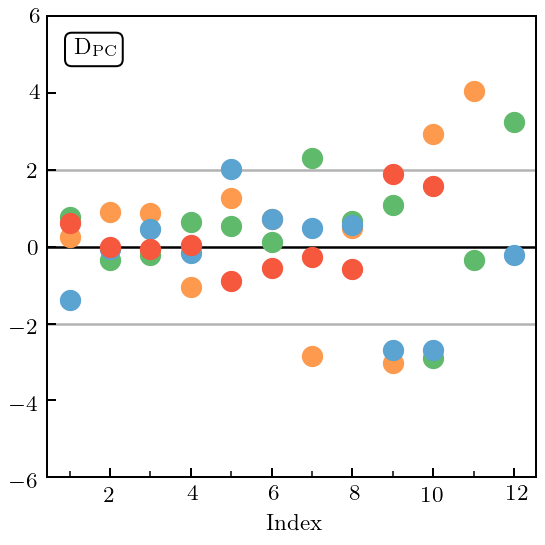

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


test first: 41.15615720501535 41.15615720501535
test last: 540403.3396297457 510383.2183257157
(5, 350, 13)
(5, 350, 12)
data = [[[-0.00347933 -0.00695831 -0.01043659 ... -0.37590779 -0.37581195
   -0.37499677]
  [-0.00539993 -0.01079927 -0.01619745 ... -0.5717322  -0.57158093
   -0.57033843]
  [-0.00635483 -0.01270893 -0.0190616  ... -0.66015362 -0.65997245
   -0.65853461]
  ...
  [ 0.01336704  0.02682815  0.04047047 ... -0.62090971 -0.62577477
   -0.62746975]
  [ 0.01341955  0.02693334  0.04062867 ... -0.62013542 -0.62501845
   -0.62672537]
  [ 0.01347193  0.02703829  0.0407865  ... -0.61935691 -0.62425792
   -0.62597678]]

 [[-0.00348423 -0.00696811 -0.01045129 ... -0.37661496 -0.37651902
   -0.37570236]
  [-0.00533964 -0.01067871 -0.01601661 ... -0.564842   -0.56469241
   -0.5634648 ]
  [-0.00625279 -0.01250486 -0.0187555  ... -0.64803676 -0.64785846
   -0.64644674]
  ...
  [ 0.00697803  0.01400803  0.02113911 ...  0.38103807  0.37562347
    0.37170634]
  [ 0.00692988  0.01391126  

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


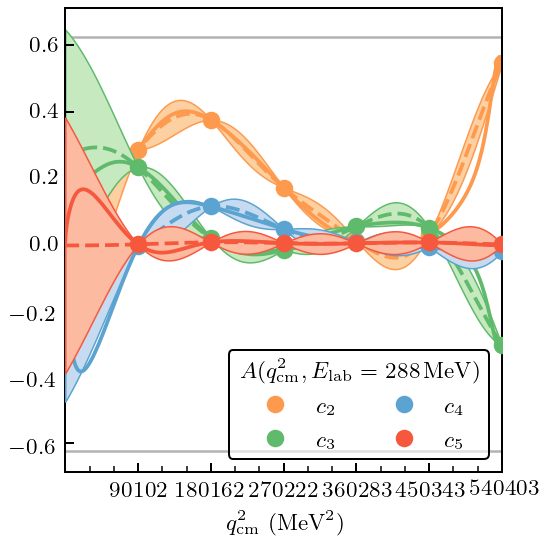

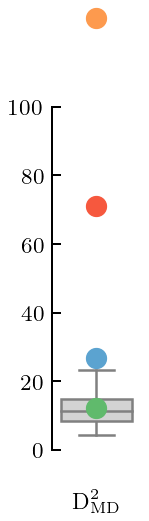

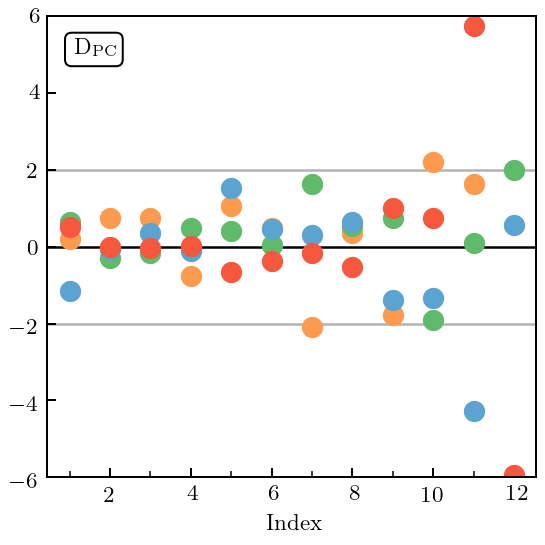

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:625: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + self.observable_name + \


In [12]:
# runs through the observables
for m, observable in enumerate(vsangle_observable_array):
    # runs through the energies at which to evaluate the observables
    for j, E_lab in enumerate(observable.energies):
        # creates the bunches for the input spaces
        DegBunch = InputSpaceBunch("deg", \
                            degrees, \
                            E_to_p(E_lab, "np"), \
                            r'$\theta$ (deg)', \
                            [r'$', observable.title, r'(\theta, E_{\mathrm{lab}}= ', E_lab, \
                             '\,\mathrm{MeV})$'])
        
        # note that the input space here is -cos(theta), not cos(theta) (as it once was)
        CosBunch = InputSpaceBunch("cos", \
                            -np.cos(np.radians(degrees)), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$-\mathrm{cos}(\theta)$', \
                            [r'$', observable.title, r'(-\mathrm{cos}(\theta), E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])

        QcmBunch = InputSpaceBunch("qcm", \
                            deg_to_qcm(E_to_p(E_lab, "np"), degrees), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$q_{\mathrm{cm}}$ (MeV)', \
                            [r'$', observable.title, r'(q_{\mathrm{cm}}, E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])

        Qcm2Bunch = InputSpaceBunch("qcm2", \
                            deg_to_qcm2(E_to_p(E_lab, "np"), degrees), \
                            np.array( [softmax_mom(E_to_p(E_lab, "np"), q) \
                                      for q in deg_to_qcm(E_to_p(E_lab, "np"), degrees)] ), \
                            r'$q_{\mathrm{cm}}^{2}$ (MeV$^{2}$)', \
                            [r'$', observable.title, r'(q_{\mathrm{cm}}^{2}, E_{\mathrm{lab}}= ', \
                             E_lab, '\,\mathrm{MeV})$'])
    
        vsangle_quantity_array = [DegBunch, CosBunch, QcmBunch, Qcm2Bunch]
        # creates each bunch's title. This eventually will be outside of the for-loop
        for bunch in vsangle_quantity_array: bunch.make_title()

        # runs through the parametrization methods
        for k, Q_param_method in enumerate(Q_param_method_array):
            # runs through the input spaces
            for i, vs_quantity in enumerate(vsangle_quantity_array):
                # runs through the training and testing masks
                for l, traintestsplit in enumerate(traintestsplit_vsangle_array):
                    # conforms the training and testing masks to each input space
                    traintestsplit.make_masks(vs_quantity.input_space, observable.data)
                    print("data = " + str(observable.data))
    
                    # chooses a starting guess for the GP length scale optimization procedure
                    length_scale_guess = observable.ls_guesses[i, j]
                    
                    # creates the GP with all its hyperparameters
                    ratio_dsg = Q_approx(vs_quantity.mom, Q_param_method, Lambda_b = Lambdab)
                    print("ratio = " + str(ratio_dsg))
                    center = 0
                    df = 1
                    disp = 0
                    scale = 1
                    GPHyper_DSG = GPHyperparameters(length_scale_guess, center, ratio_dsg, \
                                    df = df, disp = 0, scale = scale)

                    # information for naming the savefiles
                    FileName_DSG = FileNaming(MyScaleScheme.potential_string, \
                                    MyScaleScheme.cutoff_string, Q_param_method)

                    # information on the orders for each potential
                    Orders_DSG = OrderInfo(MyScaleScheme.nn_orders, nn_orders_mask, \
                                    MyScaleScheme.colors, MyScaleScheme.light_colors)

                    # creates the object used to generate and plot statistical diagnostics
                    MyDSG = VsAngleObj(observable, E_lab, Lambdab, t_lab, vs_quantity, \
                            traintestsplit, GPHyper_DSG, Orders_DSG, FileName_DSG)

                    # plots figures
                    MyDSG.PlotCoefficients()
                    MyDSG.PlotMD()
                    MyDSG.PlotPC()
                    if vs_quantity.name == "deg":
                        MyDSG.PlotPosteriorPDF(PosteriorBounds_deg)
                    elif vs_quantity.name == "cos":
                        MyDSG.PlotPosteriorPDF(PosteriorBounds_cos)

And then things follow as before: print out the kernel, define the mean and covariance, do the diagnostics, and plot Mahalanobis distance and Pivoted Cholesky errors.

### Angle-independent observables

In [13]:
# creates the training and testing masks for the total cross section
Nolowenergysplit = TrainTestSplit("nolowenergy", 3, 4, \
                            offset_train_min_factor = 100/350, xmin_train_factor = 100/350, \
                            offset_test_min_factor = 100/350, xmin_test_factor = 100/350, \
                            offset_train_max_factor = -50/350, offset_test_max_factor = -50/350)
Yeslowenergysplit = TrainTestSplit("yeslowenergy", 4, 4, \
                            offset_train_min_factor = 0, xmin_train_factor = 0.01, \
                            offset_test_min_factor = 0, xmin_test_factor = 0, \
                            offset_train_max_factor = -50/350, offset_test_max_factor = -50/350)
traintestsplit_vsenergy_array = [Nolowenergysplit, Yeslowenergysplit]

In [14]:
# creates the bunch for each observable to be plotted against energy
SGTBunch = ObservableBunch("SGT", SGT, None, [100, 200], '\sigma_{\mathrm{tot}}', \
                           "dimensionful")

vsenergy_observable_array = [SGTBunch]

test first: 1 125.64285714285714
test last: 350 350.0
(5, 8)
(5, 7)
X_train has shape (3,)
y_train has shape (3, 5)
X_test has shape (7,)
y_test has shape (7, 5)
ref has shape (350,)
ref_train = [73.44588524 41.88375527 35.53121649]and has shape (3,)
ref_test = [58.91722277 50.47732783 45.25287631 39.62954417 38.02721785 36.74648565
 34.18666342]and has shape (7,)
(3, 5)
(3,)
coeffs_test = [[-1.55880915e+00  8.40938825e-01 -2.76011940e-01 -1.22373247e-03]
 [-1.30245742e+00  8.01877745e-01 -3.56995825e-01  5.54783066e-04]
 [-1.01819296e+00  7.18936197e-01 -3.81354036e-01  1.91549697e-03]
 [-5.00557203e-01  5.14485926e-01 -3.08085039e-01 -1.25331841e-03]
 [-2.92687798e-01  4.15771578e-01 -2.42843799e-01 -6.25995938e-03]
 [-1.20366527e-01  3.25457124e-01 -1.76525890e-01 -1.30223251e-02]
 [ 1.37586677e-01  1.72321480e-01 -7.31388834e-02 -2.79360944e-02]]
RBF(length_scale=150) + WhiteKernel(noise_level=1e-10)


C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:997: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout();
C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


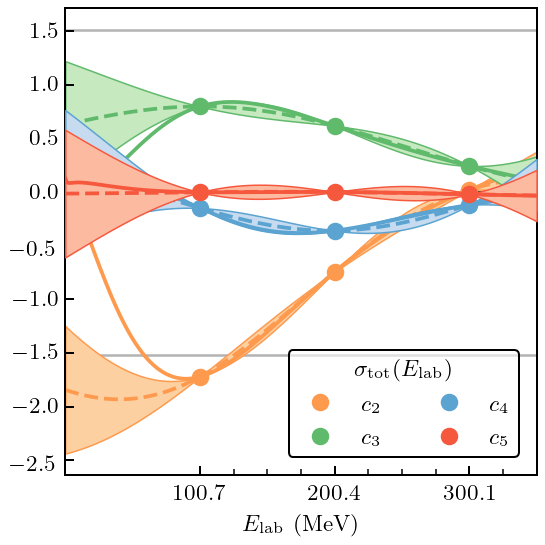

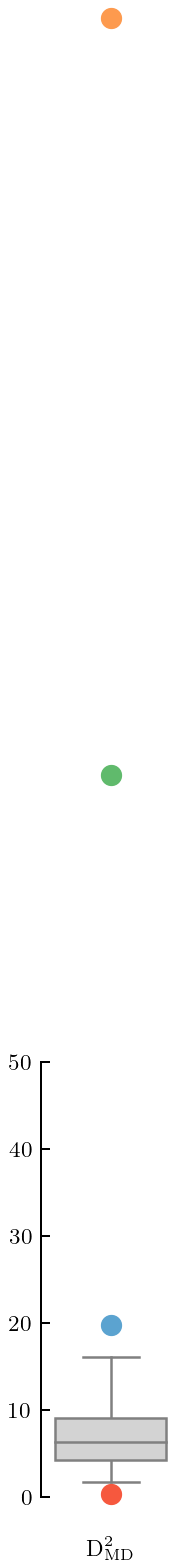

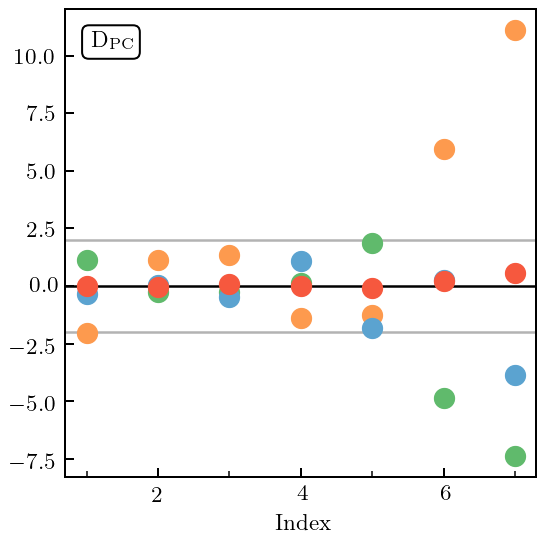

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:1026: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \


test first: 1 1.0
test last: 350 350.0
(5, 12)
(5, 11)
(5, 11)
(5, 10)
X_train has shape (3,)
y_train has shape (3, 5)
X_test has shape (10,)
y_test has shape (10, 5)
ref has shape (350,)
ref_train = [73.44588524 41.88375527 35.53121649]and has shape (3,)
ref_test = [364.67247855 164.12841536 101.18493757  58.91722277  50.47732783
  45.25287631  39.62954417  38.02721785  36.74648565  34.18666342]and has shape (10,)
(3, 5)
(3,)
coeffs_test = [[-6.78741109e-01  8.28243894e-02 -6.41089789e-02  7.07620343e-02]
 [-1.36703343e+00  3.75035003e-01  2.05068829e-02  2.97897746e-02]
 [-1.69522269e+00  6.42520266e-01 -2.11244457e-02  7.14336306e-03]
 [-1.55880915e+00  8.40938825e-01 -2.76011940e-01 -1.22373247e-03]
 [-1.30245742e+00  8.01877745e-01 -3.56995825e-01  5.54783066e-04]
 [-1.01819296e+00  7.18936197e-01 -3.81354036e-01  1.91549697e-03]
 [-5.00557203e-01  5.14485926e-01 -3.08085039e-01 -1.25331841e-03]
 [-2.92687798e-01  4.15771578e-01 -2.42843799e-01 -6.25995938e-03]
 [-1.20366527e-01  

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


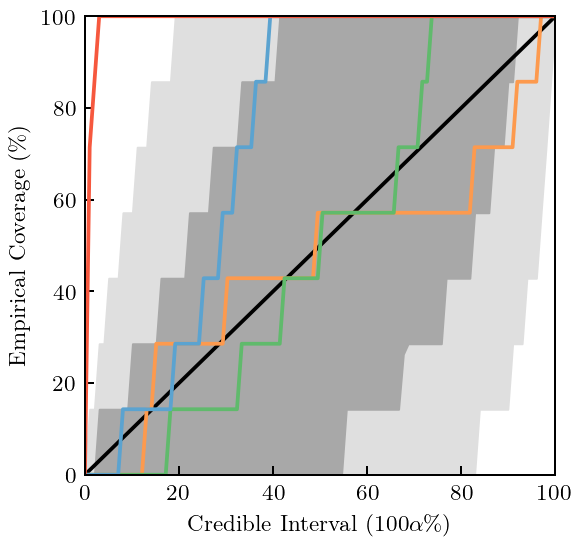

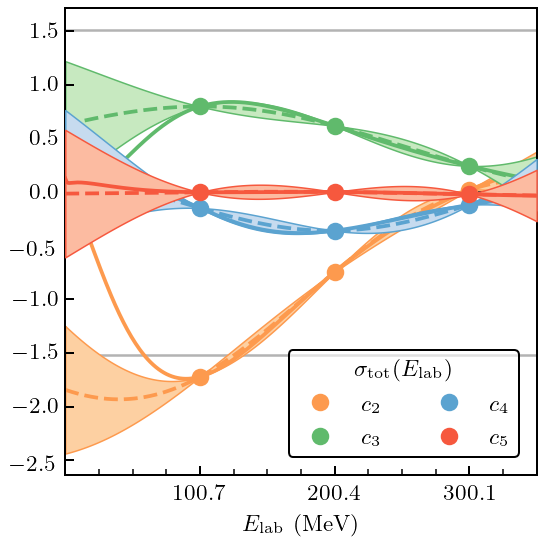

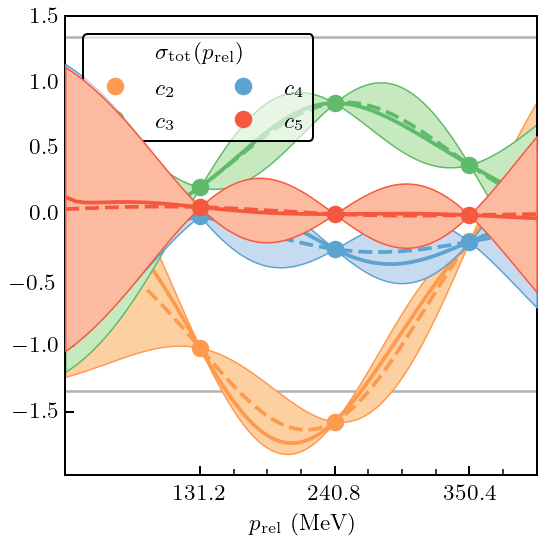

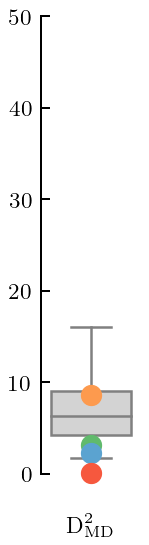

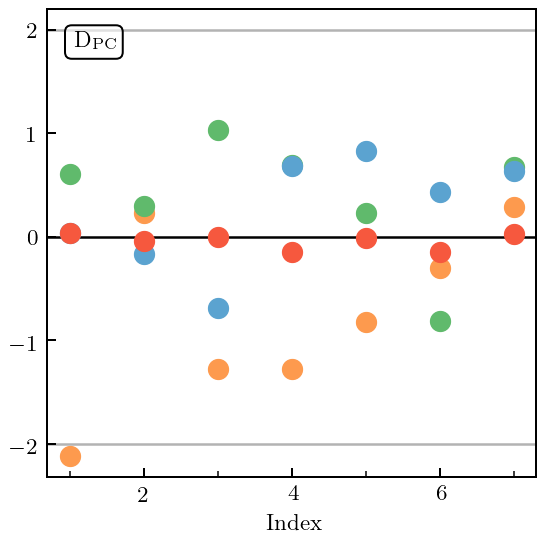

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:1026: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \


test first: 21.65954333733149 21.65954333733149
test last: 405.2129666502413 405.2129666502413
(5, 12)
(5, 11)
(5, 11)
(5, 10)
X_train has shape (3,)
y_train has shape (3, 5)
X_test has shape (10,)
y_test has shape (10, 5)
ref has shape (350,)
ref_train = [243.71773632  59.80693286  37.41543311]and has shape (3,)
ref_test = [1608.11125608  775.10339675  416.5377685   153.725812    104.45176167
   76.37633559   49.76614824   43.6193144    39.85406812   35.32165342]and has shape (10,)
(3, 5)
(3,)
coeffs_test = [[ 3.55559705e-02 -2.33170002e-02 -9.19757973e-02  8.59647226e-02]
 [-2.17928941e-01 -1.87784356e-02 -1.10899911e-01  8.97054471e-02]
 [-5.80220374e-01  5.45326274e-02 -7.76177091e-02  7.59839677e-02]
 [-1.42188114e+00  4.08624633e-01  2.25062692e-02  2.62871656e-02]
 [-1.68144153e+00  6.24526178e-01 -1.34182453e-02  8.31169746e-03]
 [-1.73205721e+00  7.84210951e-01 -1.27848862e-01 -1.65793412e-04]
 [-1.27111353e+00  7.94188616e-01 -3.62450707e-01  7.62221277e-04]
 [-8.96995809e-01

C:\Users\pjmil\anaconda3\lib\_collections_abc.py:832: MatplotlibDeprecationWarning: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]


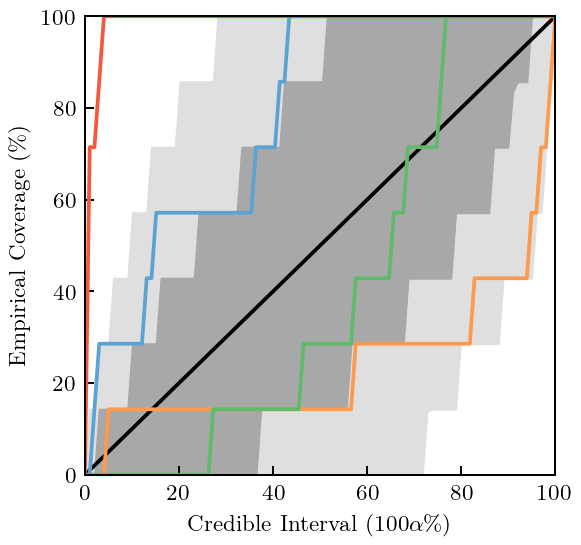

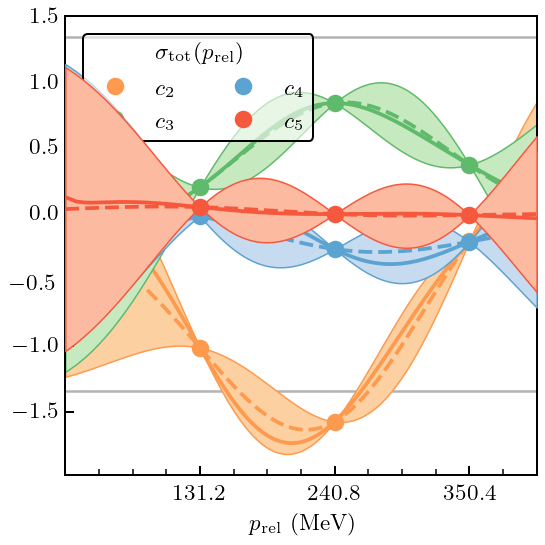

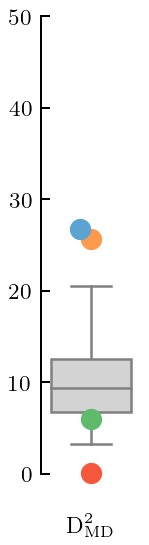

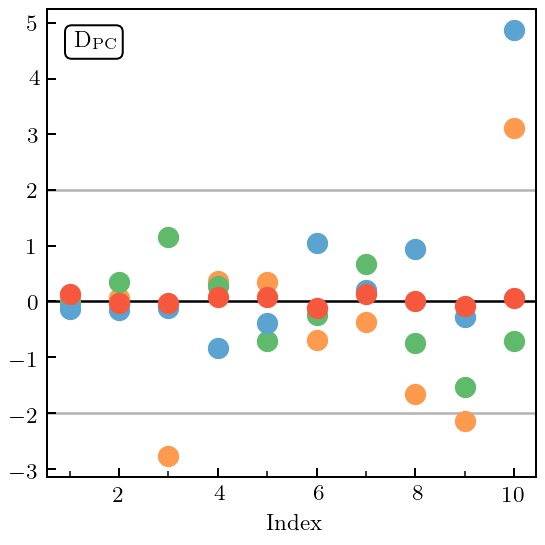

C:\Users\pjmil\Research\Correlated GP ChEFT paper\ChEFT_GP_imports.py:1026: MatplotlibDeprecationWarning: 
The make_dvi_preview function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  fig.savefig('figures/' + self.scheme + '_' + self.scale + '/' + \


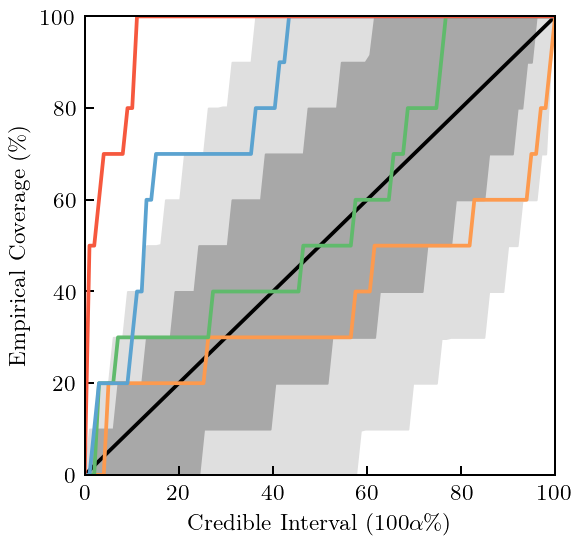

In [15]:
# runs through the observables
for m, observable in enumerate(vsenergy_observable_array):
    # creates the bunches for the input spaces
    ElabBunch = InputSpaceBunch("Elab", \
                        t_lab, \
                        E_to_p(t_lab, "np"), \
                        r'$E_{\mathrm{lab}}$ (MeV)', \
                        [r'$', observable.title, r'(E_{\mathrm{lab}})$'])

    PrelBunch = InputSpaceBunch("prel", \
                        E_to_p(t_lab, "np"), \
                        E_to_p(t_lab, "np"), \
                        r'$p_{\mathrm{rel}}$ (MeV)', \
                        [r'$', observable.title, r'(p_{\mathrm{rel}})$'])

    vsenergy_quantity_array = [ElabBunch, PrelBunch]
    # creates each bunch's title. This eventually will be outside of the for-loop
    for bunch in vsenergy_quantity_array: bunch.make_title()
    
    # runs through the parametrization methods
    for k, Q_param_method in enumerate(Q_param_method_array):
        # runs through the input spaces
        for i, vs_quantity in enumerate(vsenergy_quantity_array):
            # runs through the training and testing masks
            for l, traintestsplit in enumerate(traintestsplit_vsenergy_array):
                # conforms the training and testing masks to each input space
                traintestsplit.make_masks(vs_quantity.input_space, observable.data)
                
                # chooses a starting guess for the GP length scale optimization procedure
                length_scale_guess = observable.ls_guesses[i]
                
                # creates the GP with all its hyperparameters
                center = 0
                ratio_sgt = Q_approx(vs_quantity.mom, Q_param_method, Lambda_b = Lambdab)
                df = 1
                disp = 0
                scale = 1
                GPHyper_SGT = GPHyperparameters(length_scale_guess, center, ratio_sgt, \
                                df = df, disp = 0, scale = scale, seed = 4)
                
                # information for naming the savefiles
                FileName_SGT = FileNaming(MyScaleScheme.potential_string, \
                                MyScaleScheme.cutoff_string, Q_param_method)
                
                # information on the orders for each potential
                Orders_SGT = OrderInfo(MyScaleScheme.nn_orders, nn_orders_mask, \
                                MyScaleScheme.colors, MyScaleScheme.light_colors)
                
                # creates the object used to generate and plot statistical diagnostics
                MySGT = VsEnergyObj(observable, Lambdab, vs_quantity, traintestsplit, \
                                    GPHyper_SGT, Orders_SGT, FileName_SGT)
                
                # plots figures
                MySGT.PlotCoefficients()
                MySGT.PlotMD()
                MySGT.PlotPC()
                MySGT.PlotCredibleIntervals()

### This will plot the three parametrizations of $Q$ against relative momentum

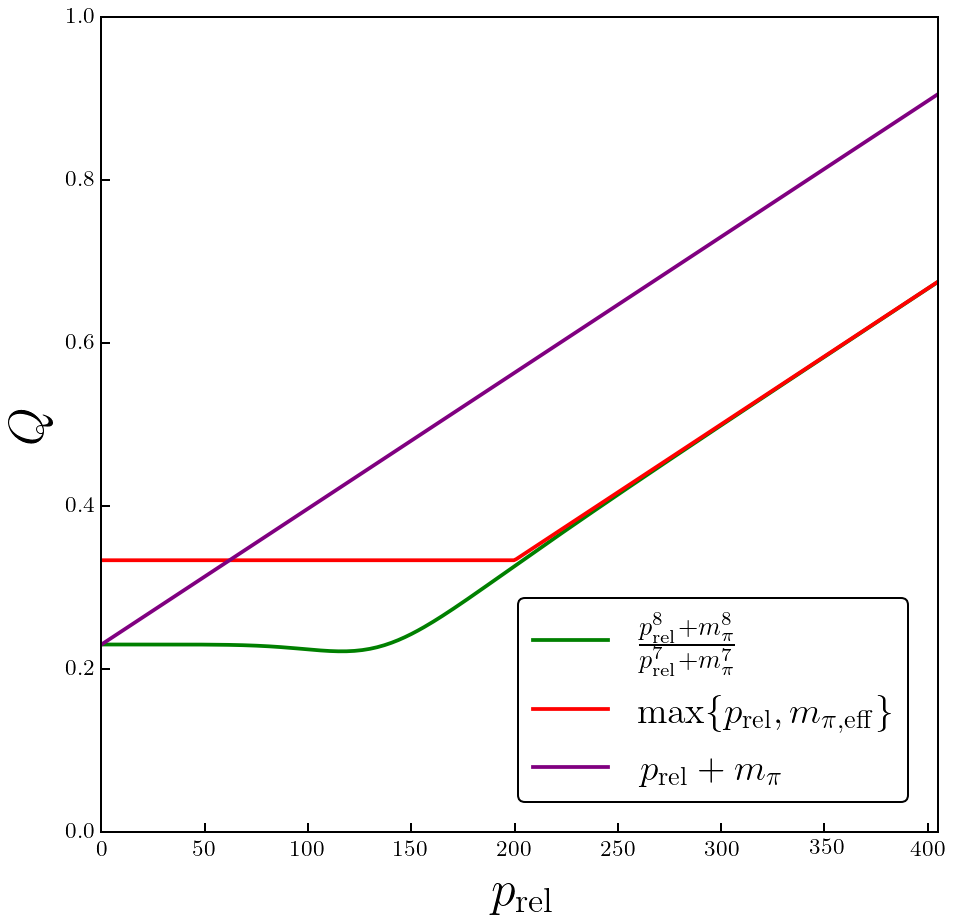

In [16]:
Elab_array = np.linspace(0, 350, 351)

fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "poly", Lambdab), \
        c = 'green', label = r'$\frac{p_{\mathrm{rel}}^{8} + m_{\pi}^{8}}{p_{\mathrm{rel}}^{7} + m_{\pi}^{7}}$')
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "max", Lambdab), \
        c = 'red', label = r'$\mathrm{max} \{p_{\mathrm{rel}}, m_{\pi, \mathrm{eff}}\}$')
ax.plot(E_to_p(Elab_array, 'np'), Q_approx(E_to_p(Elab_array, "np"), "sum", Lambdab), \
        c = 'purple', label = r'$p_{\mathrm{rel}} + m_{\pi}$')

axis_font = {'size':'20'}
ax.set_xlabel(r'$p_{\mathrm{rel}}$', **axis_font)
ax.set_ylabel(r'$Q$', **axis_font)
ax.set_ylim(0, 1)
ax.legend(loc = 'lower right', prop={'size': 15})

fig.savefig('figures/Qparamvsprel.pdf')

### Plots the PWA93 values for observables against default input space

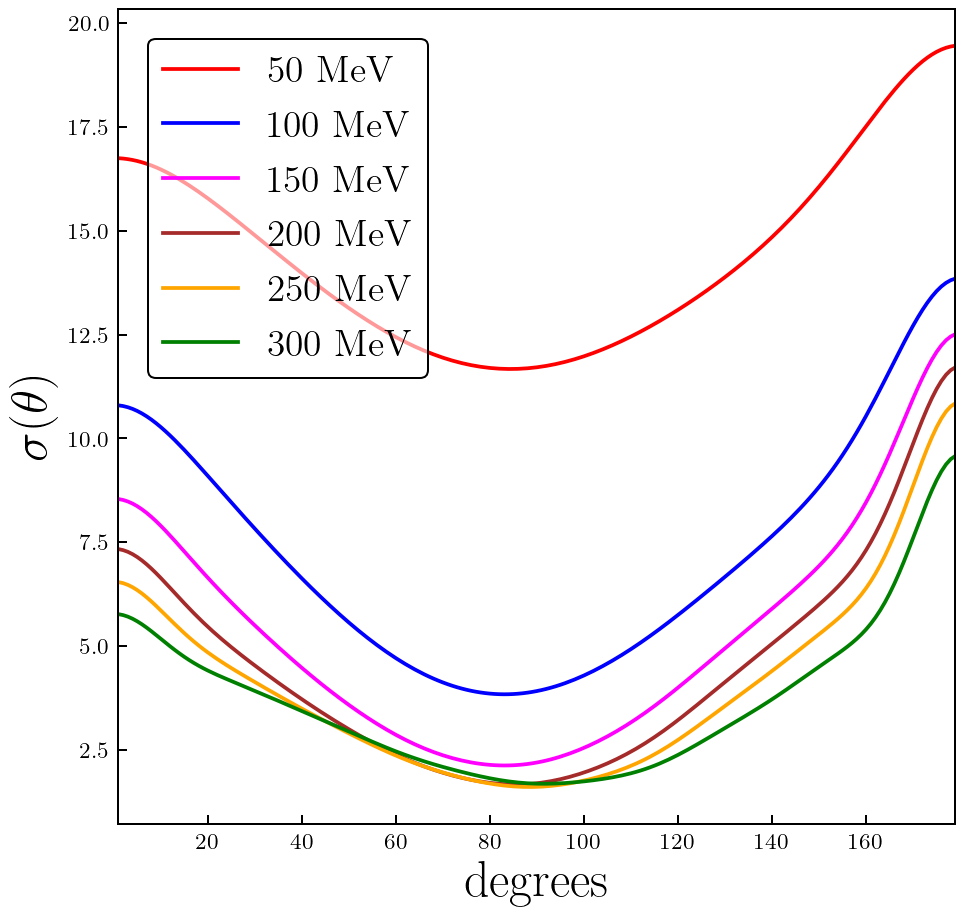

In [17]:
Elab_array = [50, 100, 150, 200, 250, 300]
color_array = ['red', 'blue', 'magenta', 'brown', 'orange', 'green']

fig, ax = plt.subplots(figsize = (6, 6))

for i, Elab in enumerate(Elab_array):
    t_lab_idx_dsg = np.nonzero(Elab == t_lab)[0][0]
    ax.plot(degrees, DSG.T[:, t_lab_idx_dsg, 4], \
            c = color_array[i], label = str(Elab) + ' MeV')

axis_font = {'size':'20'}
ax.set_xlabel('degrees', **axis_font)
ax.set_ylabel(r'$\sigma(\theta)$', **axis_font)
# ax.set_ylim(0, 1)
ax.legend(loc = 'upper left', prop={'size': 15})

fig.savefig('figures/diffcs_n4lo_pwa93_deg.pdf')

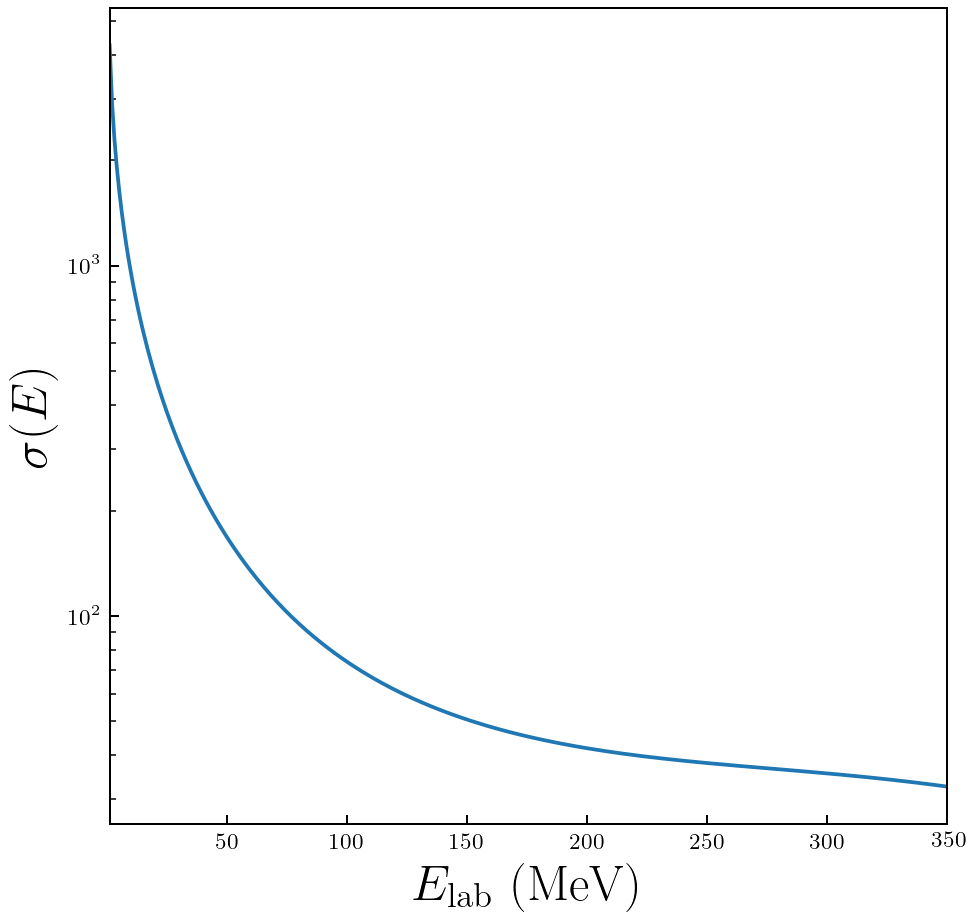

In [18]:
# Elab_array = [50, 100, 150, 200, 250, 300]
# color_array = ['red', 'blue', 'magenta', 'brown', 'orange', 'green']

fig, ax = plt.subplots(figsize = (6, 6))

ax.plot(t_lab, SGT[4, :])
axis_font = {'size':'20'}
ax.set_xlabel(r'$E_{\mathrm{lab}}$ (MeV)', **axis_font)
ax.set_ylabel(r'$\sigma(E)$', **axis_font)
ax.semilogy()

fig.savefig('figures/totalcs_n4lo_pwa93_Elab.pdf')

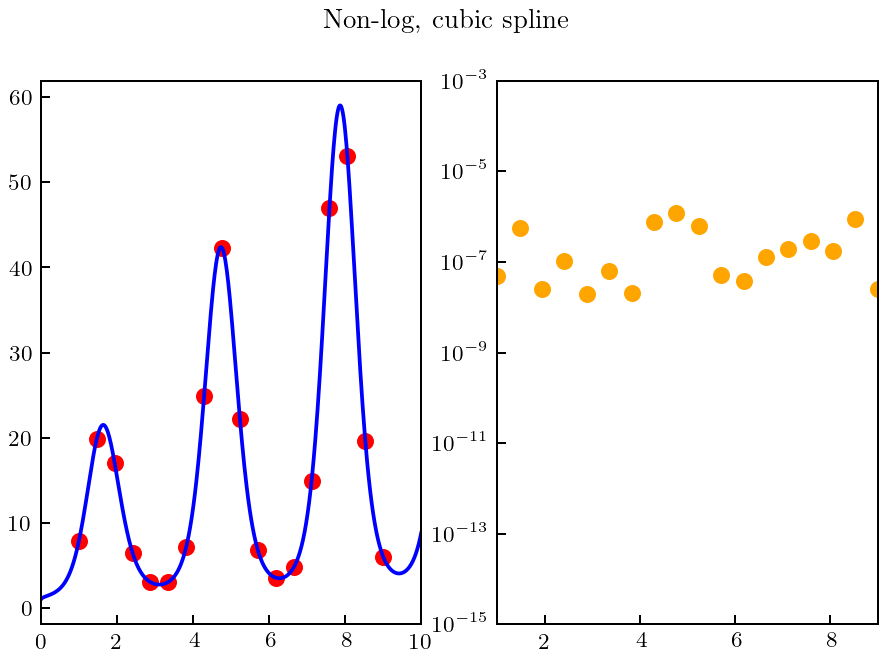

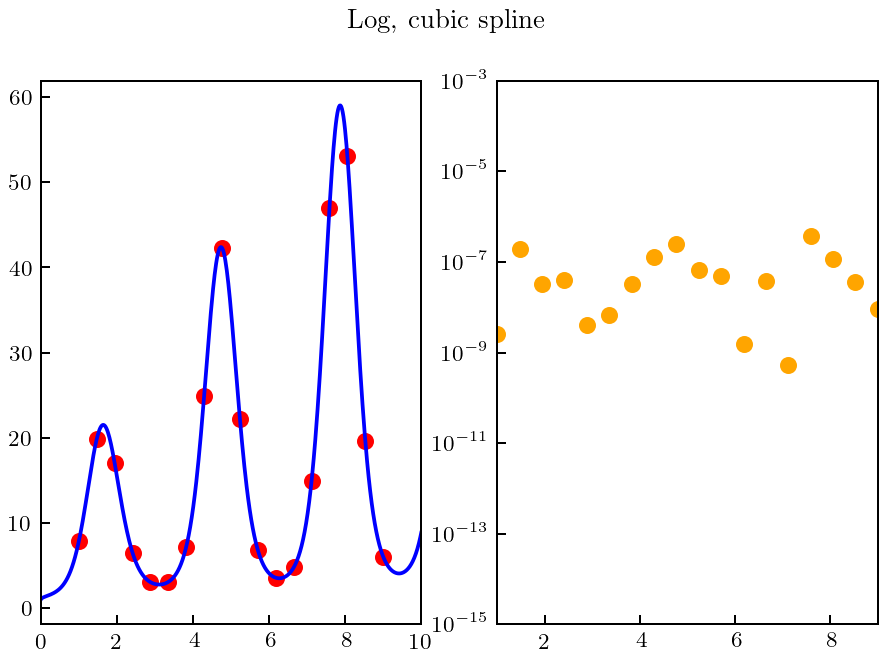

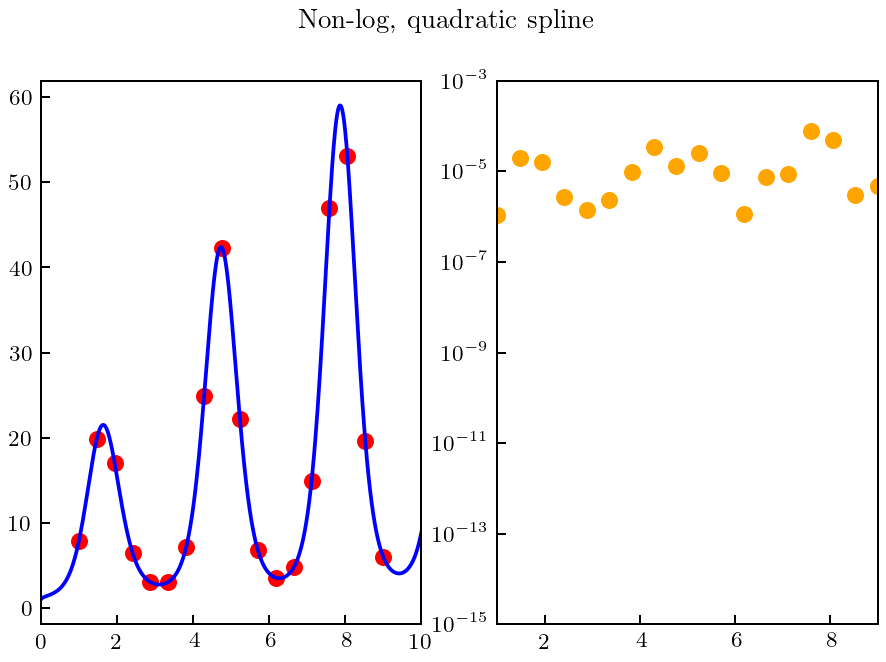

In [19]:
# %%timeit

def interp_test_plot(interpolation, test_fn, x_interp, axs, logtoexp = False):
    # creates data from the input space and the test function
    x = interpolation.x
    y = interpolation.y
    f_interp = interpolation.f_interp
    
    # uses interpolation function to generate the interpolated x and y data
    y_interp = f_interp(x_interp)
    
    # plots the "true" data (line) and the interpolated data (points)
    if not logtoexp:
        axs[0].plot(x, y, color = 'blue')
        axs[0].scatter(x_interp, y_interp, marker = 'o', color = 'red')
    elif logtoexp:
        axs[0].plot(x, np.exp(y), color = 'blue')
        axs[0].scatter(x_interp, np.exp(y_interp), marker = 'o', color = 'red')
    
    # plots the absolute value of the residual on a log scale
    if not logtoexp:
        axs[1].scatter(x_interp, np.abs(test_fn(x_interp) - y_interp), marker = 'o', \
                       color = 'orange')
        axs[1].semilogy()
        axs[1].set_ylim(1e-15, 1e-3)
    elif logtoexp:
        axs[1].scatter(x_interp, np.abs(test_fn(x_interp) - np.exp(y_interp)), marker = 'o', \
                       color = 'orange')
        axs[1].semilogy()
        axs[1].set_ylim(1e-15, 1e-3)

def interp_test_fn(x):
    return 1 + x**(0.5) * np.exp( np.sin(x)**(2) / np.exp(-(x**(0.05))) )

x_test_1 = np.linspace(0, 10, 500)
interp_reg = Interpolation(x_test_1, interp_test_fn(x_test_1), kind = 'cubic')
interp_log = Interpolation(x_test_1, np.log(interp_test_fn(x_test_1)), kind = 'cubic')
interp_quad = Interpolation(x_test_1, interp_test_fn(x_test_1), kind = 'quadratic')

x_interp = np.linspace(1, 9, 18)

fig_reg, axs_reg = plt.subplots(1, 2); fig_reg.suptitle("Non-log, cubic spline")
fig_log, axs_log = plt.subplots(1, 2); fig_log.suptitle("Log, cubic spline")
fig_quad, axs_quad = plt.subplots(1, 2); fig_quad.suptitle("Non-log, quadratic spline")

interp_test_plot(interp_reg, interp_test_fn, x_interp, axs_reg, logtoexp = False)
interp_test_plot(interp_log, interp_test_fn, x_interp, axs_log, logtoexp = True)
interp_test_plot(interp_quad, interp_test_fn, x_interp, axs_quad, logtoexp = False)